In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3467748, 828)
(3467748, 8)
validation
(489242, 828)
(489242, 8)
test
(428799, 828)
(428799, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/347 [..............................] - ETA: 7:54 - loss: 2.1969 - STD: 0.0667 - MAE: 0.2181

  4/347 [..............................] - ETA: 7s - loss: 2.0997 - STD: 0.0503 - MAE: 0.2166  

  8/347 [..............................] - ETA: 6s - loss: 2.0870 - STD: 0.0452 - MAE: 0.2166

 11/347 [..............................] - ETA: 6s - loss: 2.0773 - STD: 0.0431 - MAE: 0.2165

 14/347 [>.............................] - ETA: 5s - loss: 2.0716 - STD: 0.0411 - MAE: 0.2165

 17/347 [>.............................] - ETA: 5s - loss: 2.0672 - STD: 0.0396 - MAE: 0.2165

 20/347 [>.............................] - ETA: 5s - loss: 2.0616 - STD: 0.0388 - MAE: 0.2164

 23/347 [>.............................] - ETA: 5s - loss: 2.0551 - STD: 0.0384 - MAE: 0.2162

 26/347 [=>............................] - ETA: 5s - loss: 2.0474 - STD: 0.0385 - MAE: 0.2159

 29/347 [=>............................] - ETA: 5s - loss: 2.0382 - STD: 0.0392 - MAE: 0.2155

 32/347 [=>............................] - ETA: 5s - loss: 2.0279 - STD: 0.0412 - MAE: 0.2150

 35/347 [==>...........................] - ETA: 5s - loss: 2.0175 - STD: 0.0434 - MAE: 0.2144

 38/347 [==>...........................] - ETA: 5s - loss: 2.0060 - STD: 0.0454 - MAE: 0.2138

 42/347 [==>...........................] - ETA: 5s - loss: 1.9904 - STD: 0.0482 - MAE: 0.2130

 45/347 [==>...........................] - ETA: 5s - loss: 1.9787 - STD: 0.0502 - MAE: 0.2124

 48/347 [===>..........................] - ETA: 5s - loss: 1.9671 - STD: 0.0523 - MAE: 0.2117

 51/347 [===>..........................] - ETA: 5s - loss: 1.9558 - STD: 0.0543 - MAE: 0.2111

 54/347 [===>..........................] - ETA: 5s - loss: 1.9439 - STD: 0.0562 - MAE: 0.2105

 57/347 [===>..........................] - ETA: 5s - loss: 1.9318 - STD: 0.0582 - MAE: 0.2098

 60/347 [====>.........................] - ETA: 5s - loss: 1.9183 - STD: 0.0600 - MAE: 0.2091

 63/347 [====>.........................] - ETA: 4s - loss: 1.9038 - STD: 0.0620 - MAE: 0.2083

 66/347 [====>.........................] - ETA: 4s - loss: 1.8879 - STD: 0.0641 - MAE: 0.2074

 69/347 [====>.........................] - ETA: 4s - loss: 1.8713 - STD: 0.0665 - MAE: 0.2064

 72/347 [=====>........................] - ETA: 4s - loss: 1.8546 - STD: 0.0689 - MAE: 0.2054

 75/347 [=====>........................] - ETA: 4s - loss: 1.8375 - STD: 0.0715 - MAE: 0.2043

 78/347 [=====>........................] - ETA: 4s - loss: 1.8207 - STD: 0.0740 - MAE: 0.2032

 81/347 [======>.......................] - ETA: 4s - loss: 1.8043 - STD: 0.0765 - MAE: 0.2021

 84/347 [======>.......................] - ETA: 4s - loss: 1.7882 - STD: 0.0790 - MAE: 0.2010

 87/347 [======>.......................] - ETA: 4s - loss: 1.7725 - STD: 0.0815 - MAE: 0.1999

 90/347 [======>.......................] - ETA: 4s - loss: 1.7577 - STD: 0.0840 - MAE: 0.1988

 93/347 [=======>......................] - ETA: 4s - loss: 1.7434 - STD: 0.0863 - MAE: 0.1977

 96/347 [=======>......................] - ETA: 4s - loss: 1.7300 - STD: 0.0885 - MAE: 0.1968

 99/347 [=======>......................] - ETA: 4s - loss: 1.7169 - STD: 0.0907 - MAE: 0.1958

102/347 [=======>......................] - ETA: 4s - loss: 1.7043 - STD: 0.0928 - MAE: 0.1948

105/347 [========>.....................] - ETA: 4s - loss: 1.6924 - STD: 0.0948 - MAE: 0.1939

108/347 [========>.....................] - ETA: 4s - loss: 1.6807 - STD: 0.0967 - MAE: 0.1930

111/347 [========>.....................] - ETA: 4s - loss: 1.6697 - STD: 0.0986 - MAE: 0.1922

114/347 [========>.....................] - ETA: 4s - loss: 1.6590 - STD: 0.1003 - MAE: 0.1914

117/347 [=========>....................] - ETA: 4s - loss: 1.6488 - STD: 0.1020 - MAE: 0.1906

120/347 [=========>....................] - ETA: 4s - loss: 1.6391 - STD: 0.1037 - MAE: 0.1898

123/347 [=========>....................] - ETA: 3s - loss: 1.6297 - STD: 0.1053 - MAE: 0.1891

126/347 [=========>....................] - ETA: 3s - loss: 1.6208 - STD: 0.1068 - MAE: 0.1884

129/347 [==========>...................] - ETA: 3s - loss: 1.6119 - STD: 0.1083 - MAE: 0.1877

132/347 [==========>...................] - ETA: 3s - loss: 1.6037 - STD: 0.1096 - MAE: 0.1870

135/347 [==========>...................] - ETA: 3s - loss: 1.5954 - STD: 0.1110 - MAE: 0.1863

138/347 [==========>...................] - ETA: 3s - loss: 1.5877 - STD: 0.1124 - MAE: 0.1857

142/347 [===========>..................] - ETA: 3s - loss: 1.5777 - STD: 0.1141 - MAE: 0.1849

146/347 [===========>..................] - ETA: 3s - loss: 1.5680 - STD: 0.1157 - MAE: 0.1841

150/347 [===========>..................] - ETA: 3s - loss: 1.5588 - STD: 0.1172 - MAE: 0.1834

153/347 [============>.................] - ETA: 3s - loss: 1.5523 - STD: 0.1184 - MAE: 0.1828

156/347 [============>.................] - ETA: 3s - loss: 1.5460 - STD: 0.1195 - MAE: 0.1823

159/347 [============>.................] - ETA: 3s - loss: 1.5399 - STD: 0.1205 - MAE: 0.1818

162/347 [=============>................] - ETA: 3s - loss: 1.5339 - STD: 0.1215 - MAE: 0.1813

165/347 [=============>................] - ETA: 3s - loss: 1.5281 - STD: 0.1225 - MAE: 0.1809

169/347 [=============>................] - ETA: 3s - loss: 1.5205 - STD: 0.1239 - MAE: 0.1802

172/347 [=============>................] - ETA: 3s - loss: 1.5147 - STD: 0.1248 - MAE: 0.1797

176/347 [==============>...............] - ETA: 2s - loss: 1.5076 - STD: 0.1260 - MAE: 0.1791

179/347 [==============>...............] - ETA: 2s - loss: 1.5023 - STD: 0.1269 - MAE: 0.1787

182/347 [==============>...............] - ETA: 2s - loss: 1.4972 - STD: 0.1278 - MAE: 0.1783

185/347 [==============>...............] - ETA: 2s - loss: 1.4923 - STD: 0.1286 - MAE: 0.1779

188/347 [===============>..............] - ETA: 2s - loss: 1.4875 - STD: 0.1294 - MAE: 0.1775

192/347 [===============>..............] - ETA: 2s - loss: 1.4813 - STD: 0.1305 - MAE: 0.1769

196/347 [===============>..............] - ETA: 2s - loss: 1.4753 - STD: 0.1315 - MAE: 0.1764

200/347 [================>.............] - ETA: 2s - loss: 1.4696 - STD: 0.1325 - MAE: 0.1759

203/347 [================>.............] - ETA: 2s - loss: 1.4653 - STD: 0.1333 - MAE: 0.1756

206/347 [================>.............] - ETA: 2s - loss: 1.4612 - STD: 0.1340 - MAE: 0.1752

209/347 [=================>............] - ETA: 2s - loss: 1.4571 - STD: 0.1347 - MAE: 0.1749

212/347 [=================>............] - ETA: 2s - loss: 1.4533 - STD: 0.1354 - MAE: 0.1745

215/347 [=================>............] - ETA: 2s - loss: 1.4495 - STD: 0.1360 - MAE: 0.1742

218/347 [=================>............] - ETA: 2s - loss: 1.4456 - STD: 0.1367 - MAE: 0.1739

221/347 [==================>...........] - ETA: 2s - loss: 1.4418 - STD: 0.1373 - MAE: 0.1736

224/347 [==================>...........] - ETA: 2s - loss: 1.4383 - STD: 0.1379 - MAE: 0.1732

227/347 [==================>...........] - ETA: 2s - loss: 1.4347 - STD: 0.1385 - MAE: 0.1729

230/347 [==================>...........] - ETA: 2s - loss: 1.4311 - STD: 0.1392 - MAE: 0.1726

233/347 [===================>..........] - ETA: 1s - loss: 1.4275 - STD: 0.1397 - MAE: 0.1723

236/347 [===================>..........] - ETA: 1s - loss: 1.4242 - STD: 0.1403 - MAE: 0.1720

239/347 [===================>..........] - ETA: 1s - loss: 1.4209 - STD: 0.1409 - MAE: 0.1717

242/347 [===================>..........] - ETA: 1s - loss: 1.4175 - STD: 0.1415 - MAE: 0.1714

246/347 [====================>.........] - ETA: 1s - loss: 1.4132 - STD: 0.1422 - MAE: 0.1711

249/347 [====================>.........] - ETA: 1s - loss: 1.4100 - STD: 0.1427 - MAE: 0.1708

252/347 [====================>.........] - ETA: 1s - loss: 1.4068 - STD: 0.1433 - MAE: 0.1705

253/347 [====================>.........] - ETA: 1s - loss: 1.4061 - STD: 0.1434 - MAE: 0.1704

256/347 [=====================>........] - ETA: 1s - loss: 1.4031 - STD: 0.1440 - MAE: 0.1701

259/347 [=====================>........] - ETA: 1s - loss: 1.4001 - STD: 0.1444 - MAE: 0.1699

262/347 [=====================>........] - ETA: 1s - loss: 1.3973 - STD: 0.1449 - MAE: 0.1696

265/347 [=====================>........] - ETA: 1s - loss: 1.3945 - STD: 0.1454 - MAE: 0.1694

268/347 [======================>.......] - ETA: 1s - loss: 1.3916 - STD: 0.1459 - MAE: 0.1691

271/347 [======================>.......] - ETA: 1s - loss: 1.3887 - STD: 0.1463 - MAE: 0.1689

274/347 [======================>.......] - ETA: 1s - loss: 1.3860 - STD: 0.1468 - MAE: 0.1686

277/347 [======================>.......] - ETA: 1s - loss: 1.3833 - STD: 0.1473 - MAE: 0.1684

280/347 [=======================>......] - ETA: 1s - loss: 1.3805 - STD: 0.1477 - MAE: 0.1682

283/347 [=======================>......] - ETA: 1s - loss: 1.3779 - STD: 0.1481 - MAE: 0.1679

286/347 [=======================>......] - ETA: 1s - loss: 1.3754 - STD: 0.1486 - MAE: 0.1677

289/347 [=======================>......] - ETA: 1s - loss: 1.3728 - STD: 0.1490 - MAE: 0.1675

292/347 [========================>.....] - ETA: 1s - loss: 1.3703 - STD: 0.1494 - MAE: 0.1672

295/347 [========================>.....] - ETA: 1s - loss: 1.3678 - STD: 0.1499 - MAE: 0.1670

299/347 [========================>.....] - ETA: 0s - loss: 1.3647 - STD: 0.1504 - MAE: 0.1667

302/347 [=========================>....] - ETA: 0s - loss: 1.3624 - STD: 0.1508 - MAE: 0.1665

305/347 [=========================>....] - ETA: 0s - loss: 1.3600 - STD: 0.1512 - MAE: 0.1663

308/347 [=========================>....] - ETA: 0s - loss: 1.3576 - STD: 0.1516 - MAE: 0.1661

311/347 [=========================>....] - ETA: 0s - loss: 1.3553 - STD: 0.1520 - MAE: 0.1659

315/347 [==========================>...] - ETA: 0s - loss: 1.3523 - STD: 0.1525 - MAE: 0.1656

318/347 [==========================>...] - ETA: 0s - loss: 1.3501 - STD: 0.1528 - MAE: 0.1654

321/347 [==========================>...] - ETA: 0s - loss: 1.3478 - STD: 0.1532 - MAE: 0.1652

324/347 [===========================>..] - ETA: 0s - loss: 1.3457 - STD: 0.1535 - MAE: 0.1650

327/347 [===========================>..] - ETA: 0s - loss: 1.3435 - STD: 0.1539 - MAE: 0.1648

331/347 [===========================>..] - ETA: 0s - loss: 1.3405 - STD: 0.1544 - MAE: 0.1646

334/347 [===========================>..] - ETA: 0s - loss: 1.3385 - STD: 0.1547 - MAE: 0.1644

337/347 [============================>.] - ETA: 0s - loss: 1.3363 - STD: 0.1551 - MAE: 0.1642

340/347 [============================>.] - ETA: 0s - loss: 1.3343 - STD: 0.1554 - MAE: 0.1640

343/347 [============================>.] - ETA: 0s - loss: 1.3324 - STD: 0.1557 - MAE: 0.1638

347/347 [==============================] - ETA: 0s - loss: 1.3298 - STD: 0.1562 - MAE: 0.1636

347/347 [==============================] - 9s 23ms/step - loss: 1.3298 - STD: 0.1562 - MAE: 0.1636 - val_loss: 1.0586 - val_STD: 0.1933 - val_MAE: 0.1395


Epoch 2/10000


  1/347 [..............................] - ETA: 15s - loss: 1.0961 - STD: 0.1916 - MAE: 0.1433

  4/347 [..............................] - ETA: 6s - loss: 1.1010 - STD: 0.1926 - MAE: 0.1432 

  7/347 [..............................] - ETA: 6s - loss: 1.1033 - STD: 0.1937 - MAE: 0.1428

 10/347 [..............................] - ETA: 5s - loss: 1.1007 - STD: 0.1940 - MAE: 0.1426

 13/347 [>.............................] - ETA: 5s - loss: 1.0996 - STD: 0.1938 - MAE: 0.1426

 16/347 [>.............................] - ETA: 5s - loss: 1.1009 - STD: 0.1939 - MAE: 0.1426

 19/347 [>.............................] - ETA: 5s - loss: 1.1007 - STD: 0.1941 - MAE: 0.1425

 22/347 [>.............................] - ETA: 5s - loss: 1.0996 - STD: 0.1940 - MAE: 0.1425

 25/347 [=>............................] - ETA: 5s - loss: 1.0981 - STD: 0.1941 - MAE: 0.1423

 28/347 [=>............................] - ETA: 5s - loss: 1.0968 - STD: 0.1942 - MAE: 0.1422

 31/347 [=>............................] - ETA: 5s - loss: 1.0962 - STD: 0.1942 - MAE: 0.1422

 34/347 [=>............................] - ETA: 5s - loss: 1.0962 - STD: 0.1944 - MAE: 0.1421

 37/347 [==>...........................] - ETA: 5s - loss: 1.0965 - STD: 0.1945 - MAE: 0.1421

 40/347 [==>...........................] - ETA: 5s - loss: 1.0962 - STD: 0.1946 - MAE: 0.1420

 44/347 [==>...........................] - ETA: 5s - loss: 1.0959 - STD: 0.1947 - MAE: 0.1419

 47/347 [===>..........................] - ETA: 5s - loss: 1.0950 - STD: 0.1948 - MAE: 0.1419

 50/347 [===>..........................] - ETA: 5s - loss: 1.0945 - STD: 0.1948 - MAE: 0.1418

 53/347 [===>..........................] - ETA: 5s - loss: 1.0945 - STD: 0.1950 - MAE: 0.1418

 56/347 [===>..........................] - ETA: 5s - loss: 1.0935 - STD: 0.1950 - MAE: 0.1417

 59/347 [====>.........................] - ETA: 5s - loss: 1.0934 - STD: 0.1951 - MAE: 0.1417

 62/347 [====>.........................] - ETA: 5s - loss: 1.0934 - STD: 0.1952 - MAE: 0.1416

 65/347 [====>.........................] - ETA: 4s - loss: 1.0931 - STD: 0.1953 - MAE: 0.1416

 68/347 [====>.........................] - ETA: 4s - loss: 1.0928 - STD: 0.1953 - MAE: 0.1415

 71/347 [=====>........................] - ETA: 4s - loss: 1.0922 - STD: 0.1953 - MAE: 0.1415

 74/347 [=====>........................] - ETA: 4s - loss: 1.0916 - STD: 0.1954 - MAE: 0.1414

 77/347 [=====>........................] - ETA: 4s - loss: 1.0910 - STD: 0.1955 - MAE: 0.1414

 81/347 [======>.......................] - ETA: 4s - loss: 1.0899 - STD: 0.1955 - MAE: 0.1413

 84/347 [======>.......................] - ETA: 4s - loss: 1.0892 - STD: 0.1956 - MAE: 0.1412

 88/347 [======>.......................] - ETA: 4s - loss: 1.0882 - STD: 0.1957 - MAE: 0.1411

 92/347 [======>.......................] - ETA: 4s - loss: 1.0870 - STD: 0.1958 - MAE: 0.1410

 95/347 [=======>......................] - ETA: 4s - loss: 1.0862 - STD: 0.1960 - MAE: 0.1409

 98/347 [=======>......................] - ETA: 4s - loss: 1.0854 - STD: 0.1961 - MAE: 0.1408

101/347 [=======>......................] - ETA: 4s - loss: 1.0846 - STD: 0.1962 - MAE: 0.1407

104/347 [=======>......................] - ETA: 4s - loss: 1.0840 - STD: 0.1963 - MAE: 0.1406

108/347 [========>.....................] - ETA: 4s - loss: 1.0829 - STD: 0.1964 - MAE: 0.1405

111/347 [========>.....................] - ETA: 4s - loss: 1.0822 - STD: 0.1965 - MAE: 0.1405

114/347 [========>.....................] - ETA: 4s - loss: 1.0814 - STD: 0.1966 - MAE: 0.1404

118/347 [=========>....................] - ETA: 3s - loss: 1.0808 - STD: 0.1967 - MAE: 0.1403

121/347 [=========>....................] - ETA: 3s - loss: 1.0802 - STD: 0.1968 - MAE: 0.1402

125/347 [=========>....................] - ETA: 3s - loss: 1.0799 - STD: 0.1969 - MAE: 0.1402

128/347 [==========>...................] - ETA: 3s - loss: 1.0791 - STD: 0.1970 - MAE: 0.1401

131/347 [==========>...................] - ETA: 3s - loss: 1.0789 - STD: 0.1971 - MAE: 0.1400

134/347 [==========>...................] - ETA: 3s - loss: 1.0787 - STD: 0.1972 - MAE: 0.1400

137/347 [==========>...................] - ETA: 3s - loss: 1.0785 - STD: 0.1972 - MAE: 0.1400

140/347 [===========>..................] - ETA: 3s - loss: 1.0784 - STD: 0.1973 - MAE: 0.1399

143/347 [===========>..................] - ETA: 3s - loss: 1.0781 - STD: 0.1974 - MAE: 0.1399

147/347 [===========>..................] - ETA: 3s - loss: 1.0775 - STD: 0.1974 - MAE: 0.1398

151/347 [============>.................] - ETA: 3s - loss: 1.0771 - STD: 0.1975 - MAE: 0.1398

155/347 [============>.................] - ETA: 3s - loss: 1.0762 - STD: 0.1976 - MAE: 0.1397

158/347 [============>.................] - ETA: 3s - loss: 1.0756 - STD: 0.1977 - MAE: 0.1396

161/347 [============>.................] - ETA: 3s - loss: 1.0750 - STD: 0.1977 - MAE: 0.1396

164/347 [=============>................] - ETA: 3s - loss: 1.0745 - STD: 0.1978 - MAE: 0.1395

167/347 [=============>................] - ETA: 3s - loss: 1.0741 - STD: 0.1979 - MAE: 0.1394

170/347 [=============>................] - ETA: 3s - loss: 1.0741 - STD: 0.1979 - MAE: 0.1394

173/347 [=============>................] - ETA: 3s - loss: 1.0738 - STD: 0.1980 - MAE: 0.1394

176/347 [==============>...............] - ETA: 2s - loss: 1.0733 - STD: 0.1981 - MAE: 0.1393

179/347 [==============>...............] - ETA: 2s - loss: 1.0727 - STD: 0.1981 - MAE: 0.1393

183/347 [==============>...............] - ETA: 2s - loss: 1.0719 - STD: 0.1982 - MAE: 0.1392

186/347 [===============>..............] - ETA: 2s - loss: 1.0714 - STD: 0.1983 - MAE: 0.1391

190/347 [===============>..............] - ETA: 2s - loss: 1.0706 - STD: 0.1984 - MAE: 0.1391

193/347 [===============>..............] - ETA: 2s - loss: 1.0703 - STD: 0.1984 - MAE: 0.1390

196/347 [===============>..............] - ETA: 2s - loss: 1.0697 - STD: 0.1985 - MAE: 0.1389

199/347 [================>.............] - ETA: 2s - loss: 1.0692 - STD: 0.1986 - MAE: 0.1389

202/347 [================>.............] - ETA: 2s - loss: 1.0686 - STD: 0.1987 - MAE: 0.1388

205/347 [================>.............] - ETA: 2s - loss: 1.0680 - STD: 0.1987 - MAE: 0.1388

208/347 [================>.............] - ETA: 2s - loss: 1.0675 - STD: 0.1988 - MAE: 0.1387

211/347 [=================>............] - ETA: 2s - loss: 1.0670 - STD: 0.1988 - MAE: 0.1387

214/347 [=================>............] - ETA: 2s - loss: 1.0665 - STD: 0.1989 - MAE: 0.1386

217/347 [=================>............] - ETA: 2s - loss: 1.0660 - STD: 0.1990 - MAE: 0.1386

220/347 [==================>...........] - ETA: 2s - loss: 1.0655 - STD: 0.1991 - MAE: 0.1385

223/347 [==================>...........] - ETA: 2s - loss: 1.0651 - STD: 0.1991 - MAE: 0.1384

226/347 [==================>...........] - ETA: 2s - loss: 1.0646 - STD: 0.1992 - MAE: 0.1384

229/347 [==================>...........] - ETA: 2s - loss: 1.0642 - STD: 0.1993 - MAE: 0.1383

232/347 [===================>..........] - ETA: 2s - loss: 1.0638 - STD: 0.1993 - MAE: 0.1383

235/347 [===================>..........] - ETA: 1s - loss: 1.0633 - STD: 0.1994 - MAE: 0.1382

238/347 [===================>..........] - ETA: 1s - loss: 1.0628 - STD: 0.1995 - MAE: 0.1382

242/347 [===================>..........] - ETA: 1s - loss: 1.0622 - STD: 0.1996 - MAE: 0.1381

245/347 [====================>.........] - ETA: 1s - loss: 1.0617 - STD: 0.1996 - MAE: 0.1380

248/347 [====================>.........] - ETA: 1s - loss: 1.0612 - STD: 0.1997 - MAE: 0.1380

251/347 [====================>.........] - ETA: 1s - loss: 1.0607 - STD: 0.1997 - MAE: 0.1379

255/347 [=====================>........] - ETA: 1s - loss: 1.0600 - STD: 0.1998 - MAE: 0.1379

259/347 [=====================>........] - ETA: 1s - loss: 1.0595 - STD: 0.1999 - MAE: 0.1378

262/347 [=====================>........] - ETA: 1s - loss: 1.0591 - STD: 0.2000 - MAE: 0.1378

265/347 [=====================>........] - ETA: 1s - loss: 1.0586 - STD: 0.2000 - MAE: 0.1377

268/347 [======================>.......] - ETA: 1s - loss: 1.0583 - STD: 0.2001 - MAE: 0.1377

271/347 [======================>.......] - ETA: 1s - loss: 1.0581 - STD: 0.2002 - MAE: 0.1376

274/347 [======================>.......] - ETA: 1s - loss: 1.0579 - STD: 0.2002 - MAE: 0.1376

277/347 [======================>.......] - ETA: 1s - loss: 1.0575 - STD: 0.2003 - MAE: 0.1375

280/347 [=======================>......] - ETA: 1s - loss: 1.0572 - STD: 0.2003 - MAE: 0.1375

283/347 [=======================>......] - ETA: 1s - loss: 1.0570 - STD: 0.2004 - MAE: 0.1375

286/347 [=======================>......] - ETA: 1s - loss: 1.0566 - STD: 0.2004 - MAE: 0.1374

289/347 [=======================>......] - ETA: 1s - loss: 1.0562 - STD: 0.2005 - MAE: 0.1374

292/347 [========================>.....] - ETA: 0s - loss: 1.0557 - STD: 0.2005 - MAE: 0.1373

295/347 [========================>.....] - ETA: 0s - loss: 1.0553 - STD: 0.2006 - MAE: 0.1373

299/347 [========================>.....] - ETA: 0s - loss: 1.0547 - STD: 0.2006 - MAE: 0.1372

303/347 [=========================>....] - ETA: 0s - loss: 1.0542 - STD: 0.2007 - MAE: 0.1372

306/347 [=========================>....] - ETA: 0s - loss: 1.0538 - STD: 0.2008 - MAE: 0.1371

309/347 [=========================>....] - ETA: 0s - loss: 1.0534 - STD: 0.2008 - MAE: 0.1371

312/347 [=========================>....] - ETA: 0s - loss: 1.0529 - STD: 0.2009 - MAE: 0.1370

315/347 [==========================>...] - ETA: 0s - loss: 1.0526 - STD: 0.2009 - MAE: 0.1370

318/347 [==========================>...] - ETA: 0s - loss: 1.0522 - STD: 0.2010 - MAE: 0.1370

321/347 [==========================>...] - ETA: 0s - loss: 1.0518 - STD: 0.2011 - MAE: 0.1369

325/347 [===========================>..] - ETA: 0s - loss: 1.0518 - STD: 0.2011 - MAE: 0.1369

329/347 [===========================>..] - ETA: 0s - loss: 1.0514 - STD: 0.2012 - MAE: 0.1368

333/347 [===========================>..] - ETA: 0s - loss: 1.0511 - STD: 0.2013 - MAE: 0.1368

336/347 [============================>.] - ETA: 0s - loss: 1.0509 - STD: 0.2013 - MAE: 0.1367

339/347 [============================>.] - ETA: 0s - loss: 1.0505 - STD: 0.2014 - MAE: 0.1367

342/347 [============================>.] - ETA: 0s - loss: 1.0502 - STD: 0.2014 - MAE: 0.1367

346/347 [============================>.] - ETA: 0s - loss: 1.0498 - STD: 0.2015 - MAE: 0.1366

347/347 [==============================] - 7s 20ms/step - loss: 1.0497 - STD: 0.2015 - MAE: 0.1366 - val_loss: 0.9869 - val_STD: 0.2080 - val_MAE: 0.1299


Epoch 3/10000


  1/347 [..............................] - ETA: 17s - loss: 1.0225 - STD: 0.2074 - MAE: 0.1326

  4/347 [..............................] - ETA: 6s - loss: 1.0064 - STD: 0.2073 - MAE: 0.1318 

  7/347 [..............................] - ETA: 6s - loss: 1.0042 - STD: 0.2069 - MAE: 0.1318

 10/347 [..............................] - ETA: 5s - loss: 1.0021 - STD: 0.2070 - MAE: 0.1316

 13/347 [>.............................] - ETA: 5s - loss: 1.0005 - STD: 0.2072 - MAE: 0.1315

 16/347 [>.............................] - ETA: 5s - loss: 1.0012 - STD: 0.2073 - MAE: 0.1315

 19/347 [>.............................] - ETA: 5s - loss: 1.0030 - STD: 0.2075 - MAE: 0.1315

 22/347 [>.............................] - ETA: 5s - loss: 1.0023 - STD: 0.2075 - MAE: 0.1315

 26/347 [=>............................] - ETA: 5s - loss: 1.0011 - STD: 0.2076 - MAE: 0.1314

 29/347 [=>............................] - ETA: 5s - loss: 1.0002 - STD: 0.2076 - MAE: 0.1313

 32/347 [=>............................] - ETA: 5s - loss: 0.9993 - STD: 0.2078 - MAE: 0.1312

 35/347 [==>...........................] - ETA: 5s - loss: 0.9997 - STD: 0.2079 - MAE: 0.1312

 38/347 [==>...........................] - ETA: 5s - loss: 0.9998 - STD: 0.2079 - MAE: 0.1311

 41/347 [==>...........................] - ETA: 5s - loss: 1.0001 - STD: 0.2080 - MAE: 0.1311

 45/347 [==>...........................] - ETA: 5s - loss: 0.9993 - STD: 0.2080 - MAE: 0.1311

 48/347 [===>..........................] - ETA: 5s - loss: 0.9987 - STD: 0.2081 - MAE: 0.1310

 51/347 [===>..........................] - ETA: 5s - loss: 0.9980 - STD: 0.2081 - MAE: 0.1309

 54/347 [===>..........................] - ETA: 5s - loss: 0.9973 - STD: 0.2082 - MAE: 0.1308

 57/347 [===>..........................] - ETA: 5s - loss: 0.9969 - STD: 0.2082 - MAE: 0.1308

 60/347 [====>.........................] - ETA: 5s - loss: 0.9963 - STD: 0.2083 - MAE: 0.1307

 63/347 [====>.........................] - ETA: 5s - loss: 0.9961 - STD: 0.2084 - MAE: 0.1307

 66/347 [====>.........................] - ETA: 4s - loss: 0.9959 - STD: 0.2085 - MAE: 0.1306

 69/347 [====>.........................] - ETA: 4s - loss: 0.9959 - STD: 0.2084 - MAE: 0.1307

 72/347 [=====>........................] - ETA: 4s - loss: 0.9959 - STD: 0.2085 - MAE: 0.1306

 75/347 [=====>........................] - ETA: 4s - loss: 0.9951 - STD: 0.2086 - MAE: 0.1306

 78/347 [=====>........................] - ETA: 4s - loss: 0.9946 - STD: 0.2086 - MAE: 0.1305

 81/347 [======>.......................] - ETA: 4s - loss: 0.9943 - STD: 0.2086 - MAE: 0.1305

 84/347 [======>.......................] - ETA: 4s - loss: 0.9941 - STD: 0.2087 - MAE: 0.1304

 87/347 [======>.......................] - ETA: 4s - loss: 0.9934 - STD: 0.2087 - MAE: 0.1304

 90/347 [======>.......................] - ETA: 4s - loss: 0.9928 - STD: 0.2088 - MAE: 0.1303

 93/347 [=======>......................] - ETA: 4s - loss: 0.9926 - STD: 0.2088 - MAE: 0.1303

 97/347 [=======>......................] - ETA: 4s - loss: 0.9919 - STD: 0.2089 - MAE: 0.1302

100/347 [=======>......................] - ETA: 4s - loss: 0.9917 - STD: 0.2089 - MAE: 0.1302

103/347 [=======>......................] - ETA: 4s - loss: 0.9916 - STD: 0.2090 - MAE: 0.1302

106/347 [========>.....................] - ETA: 4s - loss: 0.9914 - STD: 0.2090 - MAE: 0.1301

109/347 [========>.....................] - ETA: 4s - loss: 0.9915 - STD: 0.2091 - MAE: 0.1301

112/347 [========>.....................] - ETA: 4s - loss: 0.9912 - STD: 0.2091 - MAE: 0.1301

115/347 [========>.....................] - ETA: 4s - loss: 0.9908 - STD: 0.2092 - MAE: 0.1300

118/347 [=========>....................] - ETA: 4s - loss: 0.9908 - STD: 0.2092 - MAE: 0.1300

121/347 [=========>....................] - ETA: 4s - loss: 0.9911 - STD: 0.2093 - MAE: 0.1300

124/347 [=========>....................] - ETA: 3s - loss: 0.9909 - STD: 0.2093 - MAE: 0.1300

127/347 [=========>....................] - ETA: 3s - loss: 0.9909 - STD: 0.2094 - MAE: 0.1300

130/347 [==========>...................] - ETA: 3s - loss: 0.9907 - STD: 0.2094 - MAE: 0.1299

134/347 [==========>...................] - ETA: 3s - loss: 0.9902 - STD: 0.2094 - MAE: 0.1299

137/347 [==========>...................] - ETA: 3s - loss: 0.9900 - STD: 0.2095 - MAE: 0.1299

140/347 [===========>..................] - ETA: 3s - loss: 0.9898 - STD: 0.2095 - MAE: 0.1298

143/347 [===========>..................] - ETA: 3s - loss: 0.9896 - STD: 0.2095 - MAE: 0.1298

147/347 [===========>..................] - ETA: 3s - loss: 0.9893 - STD: 0.2096 - MAE: 0.1298

150/347 [===========>..................] - ETA: 3s - loss: 0.9891 - STD: 0.2096 - MAE: 0.1298

154/347 [============>.................] - ETA: 3s - loss: 0.9887 - STD: 0.2097 - MAE: 0.1297

157/347 [============>.................] - ETA: 3s - loss: 0.9885 - STD: 0.2097 - MAE: 0.1297

160/347 [============>.................] - ETA: 3s - loss: 0.9881 - STD: 0.2097 - MAE: 0.1297

163/347 [=============>................] - ETA: 3s - loss: 0.9878 - STD: 0.2097 - MAE: 0.1296

166/347 [=============>................] - ETA: 3s - loss: 0.9874 - STD: 0.2097 - MAE: 0.1296

169/347 [=============>................] - ETA: 3s - loss: 0.9871 - STD: 0.2098 - MAE: 0.1296

173/347 [=============>................] - ETA: 3s - loss: 0.9870 - STD: 0.2098 - MAE: 0.1295

176/347 [==============>...............] - ETA: 3s - loss: 0.9868 - STD: 0.2099 - MAE: 0.1295

179/347 [==============>...............] - ETA: 2s - loss: 0.9867 - STD: 0.2099 - MAE: 0.1295

182/347 [==============>...............] - ETA: 2s - loss: 0.9866 - STD: 0.2100 - MAE: 0.1295

185/347 [==============>...............] - ETA: 2s - loss: 0.9864 - STD: 0.2100 - MAE: 0.1295

188/347 [===============>..............] - ETA: 2s - loss: 0.9862 - STD: 0.2100 - MAE: 0.1294

191/347 [===============>..............] - ETA: 2s - loss: 0.9859 - STD: 0.2100 - MAE: 0.1294

195/347 [===============>..............] - ETA: 2s - loss: 0.9859 - STD: 0.2101 - MAE: 0.1294

198/347 [================>.............] - ETA: 2s - loss: 0.9858 - STD: 0.2102 - MAE: 0.1293

201/347 [================>.............] - ETA: 2s - loss: 0.9856 - STD: 0.2102 - MAE: 0.1293

204/347 [================>.............] - ETA: 2s - loss: 0.9854 - STD: 0.2102 - MAE: 0.1293

207/347 [================>.............] - ETA: 2s - loss: 0.9852 - STD: 0.2102 - MAE: 0.1293

210/347 [=================>............] - ETA: 2s - loss: 0.9851 - STD: 0.2103 - MAE: 0.1293

213/347 [=================>............] - ETA: 2s - loss: 0.9851 - STD: 0.2103 - MAE: 0.1292

216/347 [=================>............] - ETA: 2s - loss: 0.9849 - STD: 0.2103 - MAE: 0.1292

219/347 [=================>............] - ETA: 2s - loss: 0.9850 - STD: 0.2104 - MAE: 0.1292

222/347 [==================>...........] - ETA: 2s - loss: 0.9852 - STD: 0.2104 - MAE: 0.1292

225/347 [==================>...........] - ETA: 2s - loss: 0.9852 - STD: 0.2104 - MAE: 0.1292

229/347 [==================>...........] - ETA: 2s - loss: 0.9849 - STD: 0.2105 - MAE: 0.1292

232/347 [===================>..........] - ETA: 2s - loss: 0.9849 - STD: 0.2105 - MAE: 0.1291

235/347 [===================>..........] - ETA: 1s - loss: 0.9848 - STD: 0.2105 - MAE: 0.1291

239/347 [===================>..........] - ETA: 1s - loss: 0.9845 - STD: 0.2105 - MAE: 0.1291

242/347 [===================>..........] - ETA: 1s - loss: 0.9843 - STD: 0.2105 - MAE: 0.1291

245/347 [====================>.........] - ETA: 1s - loss: 0.9841 - STD: 0.2106 - MAE: 0.1291

249/347 [====================>.........] - ETA: 1s - loss: 0.9837 - STD: 0.2106 - MAE: 0.1290

252/347 [====================>.........] - ETA: 1s - loss: 0.9833 - STD: 0.2106 - MAE: 0.1290

255/347 [=====================>........] - ETA: 1s - loss: 0.9830 - STD: 0.2107 - MAE: 0.1290

258/347 [=====================>........] - ETA: 1s - loss: 0.9828 - STD: 0.2107 - MAE: 0.1290

261/347 [=====================>........] - ETA: 1s - loss: 0.9824 - STD: 0.2107 - MAE: 0.1289

264/347 [=====================>........] - ETA: 1s - loss: 0.9822 - STD: 0.2107 - MAE: 0.1289

267/347 [======================>.......] - ETA: 1s - loss: 0.9819 - STD: 0.2108 - MAE: 0.1289

270/347 [======================>.......] - ETA: 1s - loss: 0.9816 - STD: 0.2108 - MAE: 0.1288

273/347 [======================>.......] - ETA: 1s - loss: 0.9814 - STD: 0.2109 - MAE: 0.1288

276/347 [======================>.......] - ETA: 1s - loss: 0.9810 - STD: 0.2109 - MAE: 0.1288

279/347 [=======================>......] - ETA: 1s - loss: 0.9806 - STD: 0.2109 - MAE: 0.1287

282/347 [=======================>......] - ETA: 1s - loss: 0.9804 - STD: 0.2110 - MAE: 0.1287

285/347 [=======================>......] - ETA: 1s - loss: 0.9802 - STD: 0.2110 - MAE: 0.1287

288/347 [=======================>......] - ETA: 1s - loss: 0.9798 - STD: 0.2110 - MAE: 0.1286

291/347 [========================>.....] - ETA: 0s - loss: 0.9796 - STD: 0.2110 - MAE: 0.1286

294/347 [========================>.....] - ETA: 0s - loss: 0.9793 - STD: 0.2111 - MAE: 0.1286

297/347 [========================>.....] - ETA: 0s - loss: 0.9789 - STD: 0.2111 - MAE: 0.1285

300/347 [========================>.....] - ETA: 0s - loss: 0.9786 - STD: 0.2111 - MAE: 0.1285

303/347 [=========================>....] - ETA: 0s - loss: 0.9783 - STD: 0.2112 - MAE: 0.1285

306/347 [=========================>....] - ETA: 0s - loss: 0.9780 - STD: 0.2112 - MAE: 0.1285

309/347 [=========================>....] - ETA: 0s - loss: 0.9777 - STD: 0.2113 - MAE: 0.1284

312/347 [=========================>....] - ETA: 0s - loss: 0.9774 - STD: 0.2113 - MAE: 0.1284

315/347 [==========================>...] - ETA: 0s - loss: 0.9771 - STD: 0.2113 - MAE: 0.1284

318/347 [==========================>...] - ETA: 0s - loss: 0.9768 - STD: 0.2114 - MAE: 0.1283

321/347 [==========================>...] - ETA: 0s - loss: 0.9765 - STD: 0.2114 - MAE: 0.1283

324/347 [===========================>..] - ETA: 0s - loss: 0.9762 - STD: 0.2114 - MAE: 0.1283

328/347 [===========================>..] - ETA: 0s - loss: 0.9759 - STD: 0.2115 - MAE: 0.1282

331/347 [===========================>..] - ETA: 0s - loss: 0.9755 - STD: 0.2115 - MAE: 0.1282

334/347 [===========================>..] - ETA: 0s - loss: 0.9751 - STD: 0.2116 - MAE: 0.1281

337/347 [============================>.] - ETA: 0s - loss: 0.9749 - STD: 0.2116 - MAE: 0.1281

340/347 [============================>.] - ETA: 0s - loss: 0.9746 - STD: 0.2116 - MAE: 0.1281

343/347 [============================>.] - ETA: 0s - loss: 0.9745 - STD: 0.2117 - MAE: 0.1281

347/347 [==============================] - ETA: 0s - loss: 0.9741 - STD: 0.2117 - MAE: 0.1280

347/347 [==============================] - 7s 20ms/step - loss: 0.9741 - STD: 0.2117 - MAE: 0.1280 - val_loss: 0.9679 - val_STD: 0.2173 - val_MAE: 0.1253


Epoch 4/10000


  1/347 [..............................] - ETA: 17s - loss: 0.9327 - STD: 0.2163 - MAE: 0.1233

  4/347 [..............................] - ETA: 6s - loss: 0.9390 - STD: 0.2166 - MAE: 0.1237 

  7/347 [..............................] - ETA: 6s - loss: 0.9414 - STD: 0.2159 - MAE: 0.1242

 11/347 [..............................] - ETA: 5s - loss: 0.9427 - STD: 0.2160 - MAE: 0.1243

 15/347 [>.............................] - ETA: 5s - loss: 0.9416 - STD: 0.2160 - MAE: 0.1243

 18/347 [>.............................] - ETA: 5s - loss: 0.9411 - STD: 0.2160 - MAE: 0.1243

 21/347 [>.............................] - ETA: 5s - loss: 0.9395 - STD: 0.2161 - MAE: 0.1241

 24/347 [=>............................] - ETA: 5s - loss: 0.9394 - STD: 0.2161 - MAE: 0.1241

 27/347 [=>............................] - ETA: 5s - loss: 0.9400 - STD: 0.2162 - MAE: 0.1241

 30/347 [=>............................] - ETA: 5s - loss: 0.9396 - STD: 0.2163 - MAE: 0.1240

 33/347 [=>............................] - ETA: 5s - loss: 0.9398 - STD: 0.2163 - MAE: 0.1240

 36/347 [==>...........................] - ETA: 5s - loss: 0.9403 - STD: 0.2164 - MAE: 0.1240

 40/347 [==>...........................] - ETA: 5s - loss: 0.9412 - STD: 0.2164 - MAE: 0.1241

 43/347 [==>...........................] - ETA: 5s - loss: 0.9423 - STD: 0.2165 - MAE: 0.1242

 46/347 [==>...........................] - ETA: 5s - loss: 0.9424 - STD: 0.2165 - MAE: 0.1242

 49/347 [===>..........................] - ETA: 5s - loss: 0.9426 - STD: 0.2165 - MAE: 0.1242

 52/347 [===>..........................] - ETA: 5s - loss: 0.9423 - STD: 0.2165 - MAE: 0.1242

 55/347 [===>..........................] - ETA: 5s - loss: 0.9413 - STD: 0.2165 - MAE: 0.1241

 58/347 [====>.........................] - ETA: 5s - loss: 0.9412 - STD: 0.2165 - MAE: 0.1241

 61/347 [====>.........................] - ETA: 5s - loss: 0.9412 - STD: 0.2165 - MAE: 0.1241

 64/347 [====>.........................] - ETA: 4s - loss: 0.9403 - STD: 0.2165 - MAE: 0.1241

 67/347 [====>.........................] - ETA: 4s - loss: 0.9396 - STD: 0.2164 - MAE: 0.1240

 70/347 [=====>........................] - ETA: 4s - loss: 0.9400 - STD: 0.2165 - MAE: 0.1240

 73/347 [=====>........................] - ETA: 4s - loss: 0.9400 - STD: 0.2165 - MAE: 0.1240

 76/347 [=====>........................] - ETA: 4s - loss: 0.9400 - STD: 0.2166 - MAE: 0.1240

 80/347 [=====>........................] - ETA: 4s - loss: 0.9403 - STD: 0.2166 - MAE: 0.1240

 83/347 [======>.......................] - ETA: 4s - loss: 0.9401 - STD: 0.2166 - MAE: 0.1240

 87/347 [======>.......................] - ETA: 4s - loss: 0.9399 - STD: 0.2167 - MAE: 0.1239

 90/347 [======>.......................] - ETA: 4s - loss: 0.9394 - STD: 0.2167 - MAE: 0.1239

 94/347 [=======>......................] - ETA: 4s - loss: 0.9389 - STD: 0.2167 - MAE: 0.1239

 97/347 [=======>......................] - ETA: 4s - loss: 0.9383 - STD: 0.2167 - MAE: 0.1238

100/347 [=======>......................] - ETA: 4s - loss: 0.9385 - STD: 0.2167 - MAE: 0.1239

103/347 [=======>......................] - ETA: 4s - loss: 0.9385 - STD: 0.2167 - MAE: 0.1238

106/347 [========>.....................] - ETA: 4s - loss: 0.9383 - STD: 0.2168 - MAE: 0.1238

109/347 [========>.....................] - ETA: 4s - loss: 0.9381 - STD: 0.2168 - MAE: 0.1238

112/347 [========>.....................] - ETA: 4s - loss: 0.9378 - STD: 0.2168 - MAE: 0.1238

115/347 [========>.....................] - ETA: 4s - loss: 0.9376 - STD: 0.2168 - MAE: 0.1237

118/347 [=========>....................] - ETA: 4s - loss: 0.9373 - STD: 0.2168 - MAE: 0.1237

121/347 [=========>....................] - ETA: 3s - loss: 0.9369 - STD: 0.2169 - MAE: 0.1237

124/347 [=========>....................] - ETA: 3s - loss: 0.9367 - STD: 0.2169 - MAE: 0.1237

127/347 [=========>....................] - ETA: 3s - loss: 0.9366 - STD: 0.2169 - MAE: 0.1237

130/347 [==========>...................] - ETA: 3s - loss: 0.9370 - STD: 0.2169 - MAE: 0.1237

133/347 [==========>...................] - ETA: 3s - loss: 0.9370 - STD: 0.2169 - MAE: 0.1237

136/347 [==========>...................] - ETA: 3s - loss: 0.9367 - STD: 0.2170 - MAE: 0.1236

139/347 [===========>..................] - ETA: 3s - loss: 0.9365 - STD: 0.2170 - MAE: 0.1236

142/347 [===========>..................] - ETA: 3s - loss: 0.9363 - STD: 0.2170 - MAE: 0.1236

145/347 [===========>..................] - ETA: 3s - loss: 0.9363 - STD: 0.2170 - MAE: 0.1236

148/347 [===========>..................] - ETA: 3s - loss: 0.9364 - STD: 0.2171 - MAE: 0.1236

151/347 [============>.................] - ETA: 3s - loss: 0.9362 - STD: 0.2171 - MAE: 0.1235

154/347 [============>.................] - ETA: 3s - loss: 0.9360 - STD: 0.2171 - MAE: 0.1235

157/347 [============>.................] - ETA: 3s - loss: 0.9359 - STD: 0.2172 - MAE: 0.1235

160/347 [============>.................] - ETA: 3s - loss: 0.9358 - STD: 0.2172 - MAE: 0.1235

163/347 [=============>................] - ETA: 3s - loss: 0.9357 - STD: 0.2172 - MAE: 0.1235

166/347 [=============>................] - ETA: 3s - loss: 0.9355 - STD: 0.2172 - MAE: 0.1235

169/347 [=============>................] - ETA: 3s - loss: 0.9353 - STD: 0.2172 - MAE: 0.1234

172/347 [=============>................] - ETA: 3s - loss: 0.9349 - STD: 0.2172 - MAE: 0.1234

175/347 [==============>...............] - ETA: 3s - loss: 0.9346 - STD: 0.2173 - MAE: 0.1234

178/347 [==============>...............] - ETA: 2s - loss: 0.9344 - STD: 0.2173 - MAE: 0.1233

181/347 [==============>...............] - ETA: 2s - loss: 0.9341 - STD: 0.2173 - MAE: 0.1233

185/347 [==============>...............] - ETA: 2s - loss: 0.9340 - STD: 0.2173 - MAE: 0.1233

188/347 [===============>..............] - ETA: 2s - loss: 0.9341 - STD: 0.2174 - MAE: 0.1233

191/347 [===============>..............] - ETA: 2s - loss: 0.9338 - STD: 0.2174 - MAE: 0.1233

194/347 [===============>..............] - ETA: 2s - loss: 0.9338 - STD: 0.2174 - MAE: 0.1233

197/347 [================>.............] - ETA: 2s - loss: 0.9334 - STD: 0.2174 - MAE: 0.1232

200/347 [================>.............] - ETA: 2s - loss: 0.9331 - STD: 0.2174 - MAE: 0.1232

203/347 [================>.............] - ETA: 2s - loss: 0.9328 - STD: 0.2175 - MAE: 0.1232

206/347 [================>.............] - ETA: 2s - loss: 0.9324 - STD: 0.2175 - MAE: 0.1231

209/347 [=================>............] - ETA: 2s - loss: 0.9320 - STD: 0.2175 - MAE: 0.1231

212/347 [=================>............] - ETA: 2s - loss: 0.9317 - STD: 0.2176 - MAE: 0.1231

215/347 [=================>............] - ETA: 2s - loss: 0.9325 - STD: 0.2176 - MAE: 0.1231

218/347 [=================>............] - ETA: 2s - loss: 0.9326 - STD: 0.2176 - MAE: 0.1231

221/347 [==================>...........] - ETA: 2s - loss: 0.9327 - STD: 0.2177 - MAE: 0.1231

224/347 [==================>...........] - ETA: 2s - loss: 0.9325 - STD: 0.2177 - MAE: 0.1231

227/347 [==================>...........] - ETA: 2s - loss: 0.9323 - STD: 0.2177 - MAE: 0.1230

230/347 [==================>...........] - ETA: 2s - loss: 0.9321 - STD: 0.2177 - MAE: 0.1230

233/347 [===================>..........] - ETA: 2s - loss: 0.9319 - STD: 0.2177 - MAE: 0.1230

236/347 [===================>..........] - ETA: 1s - loss: 0.9317 - STD: 0.2178 - MAE: 0.1230

239/347 [===================>..........] - ETA: 1s - loss: 0.9314 - STD: 0.2178 - MAE: 0.1230

242/347 [===================>..........] - ETA: 1s - loss: 0.9312 - STD: 0.2178 - MAE: 0.1229

245/347 [====================>.........] - ETA: 1s - loss: 0.9309 - STD: 0.2178 - MAE: 0.1229

248/347 [====================>.........] - ETA: 1s - loss: 0.9308 - STD: 0.2178 - MAE: 0.1229

252/347 [====================>.........] - ETA: 1s - loss: 0.9306 - STD: 0.2179 - MAE: 0.1229

255/347 [=====================>........] - ETA: 1s - loss: 0.9304 - STD: 0.2179 - MAE: 0.1229

258/347 [=====================>........] - ETA: 1s - loss: 0.9304 - STD: 0.2179 - MAE: 0.1228

261/347 [=====================>........] - ETA: 1s - loss: 0.9302 - STD: 0.2179 - MAE: 0.1228

264/347 [=====================>........] - ETA: 1s - loss: 0.9300 - STD: 0.2179 - MAE: 0.1228

267/347 [======================>.......] - ETA: 1s - loss: 0.9299 - STD: 0.2180 - MAE: 0.1228

270/347 [======================>.......] - ETA: 1s - loss: 0.9298 - STD: 0.2180 - MAE: 0.1228

273/347 [======================>.......] - ETA: 1s - loss: 0.9295 - STD: 0.2180 - MAE: 0.1228

276/347 [======================>.......] - ETA: 1s - loss: 0.9292 - STD: 0.2180 - MAE: 0.1227

279/347 [=======================>......] - ETA: 1s - loss: 0.9290 - STD: 0.2180 - MAE: 0.1227

282/347 [=======================>......] - ETA: 1s - loss: 0.9287 - STD: 0.2181 - MAE: 0.1227

285/347 [=======================>......] - ETA: 1s - loss: 0.9285 - STD: 0.2181 - MAE: 0.1227

288/347 [=======================>......] - ETA: 1s - loss: 0.9283 - STD: 0.2181 - MAE: 0.1226

291/347 [========================>.....] - ETA: 0s - loss: 0.9282 - STD: 0.2181 - MAE: 0.1226

294/347 [========================>.....] - ETA: 0s - loss: 0.9281 - STD: 0.2182 - MAE: 0.1226

297/347 [========================>.....] - ETA: 0s - loss: 0.9279 - STD: 0.2182 - MAE: 0.1226

300/347 [========================>.....] - ETA: 0s - loss: 0.9277 - STD: 0.2182 - MAE: 0.1226

303/347 [=========================>....] - ETA: 0s - loss: 0.9274 - STD: 0.2182 - MAE: 0.1225

307/347 [=========================>....] - ETA: 0s - loss: 0.9271 - STD: 0.2183 - MAE: 0.1225

311/347 [=========================>....] - ETA: 0s - loss: 0.9274 - STD: 0.2183 - MAE: 0.1225

314/347 [==========================>...] - ETA: 0s - loss: 0.9274 - STD: 0.2183 - MAE: 0.1225

317/347 [==========================>...] - ETA: 0s - loss: 0.9273 - STD: 0.2183 - MAE: 0.1225

320/347 [==========================>...] - ETA: 0s - loss: 0.9272 - STD: 0.2183 - MAE: 0.1225

323/347 [==========================>...] - ETA: 0s - loss: 0.9269 - STD: 0.2184 - MAE: 0.1224

326/347 [===========================>..] - ETA: 0s - loss: 0.9268 - STD: 0.2184 - MAE: 0.1224

329/347 [===========================>..] - ETA: 0s - loss: 0.9266 - STD: 0.2184 - MAE: 0.1224

332/347 [===========================>..] - ETA: 0s - loss: 0.9265 - STD: 0.2184 - MAE: 0.1224

336/347 [============================>.] - ETA: 0s - loss: 0.9262 - STD: 0.2185 - MAE: 0.1224

339/347 [============================>.] - ETA: 0s - loss: 0.9260 - STD: 0.2185 - MAE: 0.1223

342/347 [============================>.] - ETA: 0s - loss: 0.9259 - STD: 0.2185 - MAE: 0.1223

345/347 [============================>.] - ETA: 0s - loss: 0.9257 - STD: 0.2185 - MAE: 0.1223

347/347 [==============================] - 7s 20ms/step - loss: 0.9256 - STD: 0.2185 - MAE: 0.1223 - val_loss: 0.9587 - val_STD: 0.2225 - val_MAE: 0.1229


Epoch 5/10000


  1/347 [..............................] - ETA: 17s - loss: 0.8977 - STD: 0.2219 - MAE: 0.1193

  4/347 [..............................] - ETA: 6s - loss: 0.9018 - STD: 0.2208 - MAE: 0.1199 

  7/347 [..............................] - ETA: 6s - loss: 0.9043 - STD: 0.2209 - MAE: 0.1200

 10/347 [..............................] - ETA: 5s - loss: 0.9036 - STD: 0.2208 - MAE: 0.1199

 13/347 [>.............................] - ETA: 5s - loss: 0.9063 - STD: 0.2210 - MAE: 0.1200

 16/347 [>.............................] - ETA: 5s - loss: 0.9052 - STD: 0.2209 - MAE: 0.1200

 19/347 [>.............................] - ETA: 5s - loss: 0.9030 - STD: 0.2212 - MAE: 0.1198

 22/347 [>.............................] - ETA: 5s - loss: 0.9038 - STD: 0.2211 - MAE: 0.1199

 25/347 [=>............................] - ETA: 5s - loss: 0.9050 - STD: 0.2214 - MAE: 0.1198

 28/347 [=>............................] - ETA: 5s - loss: 0.9045 - STD: 0.2213 - MAE: 0.1198

 32/347 [=>............................] - ETA: 5s - loss: 0.9047 - STD: 0.2213 - MAE: 0.1198

 36/347 [==>...........................] - ETA: 5s - loss: 0.9042 - STD: 0.2213 - MAE: 0.1198

 39/347 [==>...........................] - ETA: 5s - loss: 0.9030 - STD: 0.2213 - MAE: 0.1197

 42/347 [==>...........................] - ETA: 5s - loss: 0.9034 - STD: 0.2214 - MAE: 0.1197

 45/347 [==>...........................] - ETA: 5s - loss: 0.9033 - STD: 0.2214 - MAE: 0.1197

 48/347 [===>..........................] - ETA: 5s - loss: 0.9035 - STD: 0.2214 - MAE: 0.1197

 51/347 [===>..........................] - ETA: 5s - loss: 0.9035 - STD: 0.2214 - MAE: 0.1197

 54/347 [===>..........................] - ETA: 5s - loss: 0.9027 - STD: 0.2213 - MAE: 0.1197

 57/347 [===>..........................] - ETA: 4s - loss: 0.9025 - STD: 0.2214 - MAE: 0.1196

 60/347 [====>.........................] - ETA: 4s - loss: 0.9022 - STD: 0.2214 - MAE: 0.1196

 63/347 [====>.........................] - ETA: 4s - loss: 0.9015 - STD: 0.2215 - MAE: 0.1196

 66/347 [====>.........................] - ETA: 4s - loss: 0.9013 - STD: 0.2215 - MAE: 0.1195

 69/347 [====>.........................] - ETA: 4s - loss: 0.9011 - STD: 0.2215 - MAE: 0.1195

 72/347 [=====>........................] - ETA: 4s - loss: 0.9010 - STD: 0.2215 - MAE: 0.1195

 75/347 [=====>........................] - ETA: 4s - loss: 0.9005 - STD: 0.2215 - MAE: 0.1195

 78/347 [=====>........................] - ETA: 4s - loss: 0.9003 - STD: 0.2215 - MAE: 0.1195

 81/347 [======>.......................] - ETA: 4s - loss: 0.8997 - STD: 0.2215 - MAE: 0.1194

 84/347 [======>.......................] - ETA: 4s - loss: 0.8996 - STD: 0.2216 - MAE: 0.1194

 88/347 [======>.......................] - ETA: 4s - loss: 0.9003 - STD: 0.2216 - MAE: 0.1194

 91/347 [======>.......................] - ETA: 4s - loss: 0.9001 - STD: 0.2217 - MAE: 0.1194

 94/347 [=======>......................] - ETA: 4s - loss: 0.9007 - STD: 0.2217 - MAE: 0.1194

 97/347 [=======>......................] - ETA: 4s - loss: 0.9007 - STD: 0.2217 - MAE: 0.1194

100/347 [=======>......................] - ETA: 4s - loss: 0.9004 - STD: 0.2217 - MAE: 0.1194

103/347 [=======>......................] - ETA: 4s - loss: 0.9005 - STD: 0.2217 - MAE: 0.1194

106/347 [========>.....................] - ETA: 4s - loss: 0.9002 - STD: 0.2217 - MAE: 0.1194

109/347 [========>.....................] - ETA: 4s - loss: 0.9001 - STD: 0.2217 - MAE: 0.1194

112/347 [========>.....................] - ETA: 4s - loss: 0.8997 - STD: 0.2218 - MAE: 0.1193

115/347 [========>.....................] - ETA: 4s - loss: 0.8996 - STD: 0.2218 - MAE: 0.1193

118/347 [=========>....................] - ETA: 3s - loss: 0.8997 - STD: 0.2218 - MAE: 0.1193

121/347 [=========>....................] - ETA: 3s - loss: 0.8997 - STD: 0.2218 - MAE: 0.1193

124/347 [=========>....................] - ETA: 3s - loss: 0.8999 - STD: 0.2218 - MAE: 0.1193

127/347 [=========>....................] - ETA: 3s - loss: 0.8999 - STD: 0.2218 - MAE: 0.1193

130/347 [==========>...................] - ETA: 3s - loss: 0.8995 - STD: 0.2219 - MAE: 0.1193

133/347 [==========>...................] - ETA: 3s - loss: 0.8993 - STD: 0.2219 - MAE: 0.1193

136/347 [==========>...................] - ETA: 3s - loss: 0.8991 - STD: 0.2219 - MAE: 0.1192

139/347 [===========>..................] - ETA: 3s - loss: 0.8991 - STD: 0.2219 - MAE: 0.1192

142/347 [===========>..................] - ETA: 3s - loss: 0.8989 - STD: 0.2219 - MAE: 0.1192

145/347 [===========>..................] - ETA: 3s - loss: 0.8985 - STD: 0.2219 - MAE: 0.1192

148/347 [===========>..................] - ETA: 3s - loss: 0.8983 - STD: 0.2219 - MAE: 0.1192

152/347 [============>.................] - ETA: 3s - loss: 0.8977 - STD: 0.2220 - MAE: 0.1191

156/347 [============>.................] - ETA: 3s - loss: 0.8973 - STD: 0.2220 - MAE: 0.1191

159/347 [============>.................] - ETA: 3s - loss: 0.8974 - STD: 0.2220 - MAE: 0.1191

162/347 [=============>................] - ETA: 3s - loss: 0.8975 - STD: 0.2221 - MAE: 0.1190

165/347 [=============>................] - ETA: 3s - loss: 0.8977 - STD: 0.2221 - MAE: 0.1190

168/347 [=============>................] - ETA: 3s - loss: 0.8975 - STD: 0.2222 - MAE: 0.1190

171/347 [=============>................] - ETA: 3s - loss: 0.8979 - STD: 0.2222 - MAE: 0.1190

174/347 [==============>...............] - ETA: 3s - loss: 0.8979 - STD: 0.2222 - MAE: 0.1190

177/347 [==============>...............] - ETA: 2s - loss: 0.8981 - STD: 0.2222 - MAE: 0.1190

180/347 [==============>...............] - ETA: 2s - loss: 0.8981 - STD: 0.2222 - MAE: 0.1190

183/347 [==============>...............] - ETA: 2s - loss: 0.8981 - STD: 0.2222 - MAE: 0.1190

186/347 [===============>..............] - ETA: 2s - loss: 0.8980 - STD: 0.2222 - MAE: 0.1190

190/347 [===============>..............] - ETA: 2s - loss: 0.8980 - STD: 0.2222 - MAE: 0.1190

193/347 [===============>..............] - ETA: 2s - loss: 0.8980 - STD: 0.2223 - MAE: 0.1190

196/347 [===============>..............] - ETA: 2s - loss: 0.8979 - STD: 0.2223 - MAE: 0.1190

200/347 [================>.............] - ETA: 2s - loss: 0.8977 - STD: 0.2223 - MAE: 0.1190

203/347 [================>.............] - ETA: 2s - loss: 0.8978 - STD: 0.2223 - MAE: 0.1190

206/347 [================>.............] - ETA: 2s - loss: 0.8975 - STD: 0.2223 - MAE: 0.1190

209/347 [=================>............] - ETA: 2s - loss: 0.8974 - STD: 0.2223 - MAE: 0.1189

212/347 [=================>............] - ETA: 2s - loss: 0.8971 - STD: 0.2223 - MAE: 0.1189

215/347 [=================>............] - ETA: 2s - loss: 0.8968 - STD: 0.2223 - MAE: 0.1189

219/347 [=================>............] - ETA: 2s - loss: 0.8965 - STD: 0.2224 - MAE: 0.1189

222/347 [==================>...........] - ETA: 2s - loss: 0.8961 - STD: 0.2224 - MAE: 0.1188

225/347 [==================>...........] - ETA: 2s - loss: 0.8960 - STD: 0.2224 - MAE: 0.1188

228/347 [==================>...........] - ETA: 2s - loss: 0.8957 - STD: 0.2224 - MAE: 0.1188

231/347 [==================>...........] - ETA: 2s - loss: 0.8955 - STD: 0.2224 - MAE: 0.1188

234/347 [===================>..........] - ETA: 1s - loss: 0.8953 - STD: 0.2224 - MAE: 0.1188

238/347 [===================>..........] - ETA: 1s - loss: 0.8952 - STD: 0.2225 - MAE: 0.1187

241/347 [===================>..........] - ETA: 1s - loss: 0.8949 - STD: 0.2225 - MAE: 0.1187

244/347 [====================>.........] - ETA: 1s - loss: 0.8948 - STD: 0.2225 - MAE: 0.1187

247/347 [====================>.........] - ETA: 1s - loss: 0.8949 - STD: 0.2225 - MAE: 0.1187

250/347 [====================>.........] - ETA: 1s - loss: 0.8948 - STD: 0.2225 - MAE: 0.1187

253/347 [====================>.........] - ETA: 1s - loss: 0.8946 - STD: 0.2226 - MAE: 0.1186

257/347 [=====================>........] - ETA: 1s - loss: 0.8946 - STD: 0.2226 - MAE: 0.1186

260/347 [=====================>........] - ETA: 1s - loss: 0.8944 - STD: 0.2226 - MAE: 0.1186

263/347 [=====================>........] - ETA: 1s - loss: 0.8942 - STD: 0.2226 - MAE: 0.1186

266/347 [=====================>........] - ETA: 1s - loss: 0.8940 - STD: 0.2226 - MAE: 0.1186

269/347 [======================>.......] - ETA: 1s - loss: 0.8939 - STD: 0.2226 - MAE: 0.1186

272/347 [======================>.......] - ETA: 1s - loss: 0.8936 - STD: 0.2227 - MAE: 0.1186

275/347 [======================>.......] - ETA: 1s - loss: 0.8934 - STD: 0.2227 - MAE: 0.1185

278/347 [=======================>......] - ETA: 1s - loss: 0.8931 - STD: 0.2227 - MAE: 0.1185

282/347 [=======================>......] - ETA: 1s - loss: 0.8929 - STD: 0.2227 - MAE: 0.1185

286/347 [=======================>......] - ETA: 1s - loss: 0.8927 - STD: 0.2228 - MAE: 0.1185

289/347 [=======================>......] - ETA: 1s - loss: 0.8925 - STD: 0.2228 - MAE: 0.1184

292/347 [========================>.....] - ETA: 0s - loss: 0.8923 - STD: 0.2228 - MAE: 0.1184

295/347 [========================>.....] - ETA: 0s - loss: 0.8921 - STD: 0.2228 - MAE: 0.1184

298/347 [========================>.....] - ETA: 0s - loss: 0.8919 - STD: 0.2228 - MAE: 0.1184

301/347 [=========================>....] - ETA: 0s - loss: 0.8920 - STD: 0.2229 - MAE: 0.1184

304/347 [=========================>....] - ETA: 0s - loss: 0.8918 - STD: 0.2229 - MAE: 0.1183

307/347 [=========================>....] - ETA: 0s - loss: 0.8917 - STD: 0.2229 - MAE: 0.1183

310/347 [=========================>....] - ETA: 0s - loss: 0.8916 - STD: 0.2229 - MAE: 0.1183

313/347 [==========================>...] - ETA: 0s - loss: 0.8914 - STD: 0.2229 - MAE: 0.1183

316/347 [==========================>...] - ETA: 0s - loss: 0.8913 - STD: 0.2230 - MAE: 0.1183

319/347 [==========================>...] - ETA: 0s - loss: 0.8912 - STD: 0.2230 - MAE: 0.1183

322/347 [==========================>...] - ETA: 0s - loss: 0.8910 - STD: 0.2230 - MAE: 0.1182

325/347 [===========================>..] - ETA: 0s - loss: 0.8909 - STD: 0.2230 - MAE: 0.1182

328/347 [===========================>..] - ETA: 0s - loss: 0.8907 - STD: 0.2230 - MAE: 0.1182

332/347 [===========================>..] - ETA: 0s - loss: 0.8905 - STD: 0.2230 - MAE: 0.1182

335/347 [===========================>..] - ETA: 0s - loss: 0.8904 - STD: 0.2231 - MAE: 0.1182

338/347 [============================>.] - ETA: 0s - loss: 0.8904 - STD: 0.2231 - MAE: 0.1182

341/347 [============================>.] - ETA: 0s - loss: 0.8903 - STD: 0.2231 - MAE: 0.1182

344/347 [============================>.] - ETA: 0s - loss: 0.8902 - STD: 0.2231 - MAE: 0.1182

347/347 [==============================] - 7s 20ms/step - loss: 0.8902 - STD: 0.2231 - MAE: 0.1181 - val_loss: 0.9649 - val_STD: 0.2240 - val_MAE: 0.1226


Epoch 6/10000


  1/347 [..............................] - ETA: 15s - loss: 0.8752 - STD: 0.2235 - MAE: 0.1173

  5/347 [..............................] - ETA: 5s - loss: 0.8746 - STD: 0.2249 - MAE: 0.1167 

  8/347 [..............................] - ETA: 5s - loss: 0.8743 - STD: 0.2251 - MAE: 0.1165

 12/347 [>.............................] - ETA: 5s - loss: 0.8742 - STD: 0.2248 - MAE: 0.1167

 16/347 [>.............................] - ETA: 5s - loss: 0.8746 - STD: 0.2247 - MAE: 0.1166

 20/347 [>.............................] - ETA: 5s - loss: 0.8725 - STD: 0.2247 - MAE: 0.1165

 24/347 [=>............................] - ETA: 5s - loss: 0.8742 - STD: 0.2250 - MAE: 0.1165

 28/347 [=>............................] - ETA: 5s - loss: 0.8731 - STD: 0.2250 - MAE: 0.1163

 32/347 [=>............................] - ETA: 4s - loss: 0.8723 - STD: 0.2250 - MAE: 0.1163

 36/347 [==>...........................] - ETA: 4s - loss: 0.8731 - STD: 0.2250 - MAE: 0.1163

 40/347 [==>...........................] - ETA: 4s - loss: 0.8725 - STD: 0.2250 - MAE: 0.1163

 44/347 [==>...........................] - ETA: 4s - loss: 0.8732 - STD: 0.2251 - MAE: 0.1163

 48/347 [===>..........................] - ETA: 4s - loss: 0.8739 - STD: 0.2252 - MAE: 0.1163

 52/347 [===>..........................] - ETA: 4s - loss: 0.8739 - STD: 0.2252 - MAE: 0.1163

 56/347 [===>..........................] - ETA: 4s - loss: 0.8742 - STD: 0.2253 - MAE: 0.1162

 60/347 [====>.........................] - ETA: 4s - loss: 0.8736 - STD: 0.2253 - MAE: 0.1162

 64/347 [====>.........................] - ETA: 4s - loss: 0.8736 - STD: 0.2253 - MAE: 0.1162

 68/347 [====>.........................] - ETA: 4s - loss: 0.8730 - STD: 0.2253 - MAE: 0.1161

 72/347 [=====>........................] - ETA: 4s - loss: 0.8727 - STD: 0.2253 - MAE: 0.1161

 76/347 [=====>........................] - ETA: 4s - loss: 0.8718 - STD: 0.2254 - MAE: 0.1160

 80/347 [=====>........................] - ETA: 4s - loss: 0.8710 - STD: 0.2254 - MAE: 0.1160

 84/347 [======>.......................] - ETA: 4s - loss: 0.8701 - STD: 0.2254 - MAE: 0.1159

 88/347 [======>.......................] - ETA: 4s - loss: 0.8698 - STD: 0.2254 - MAE: 0.1159

 92/347 [======>.......................] - ETA: 4s - loss: 0.8699 - STD: 0.2255 - MAE: 0.1159

 96/347 [=======>......................] - ETA: 3s - loss: 0.8703 - STD: 0.2255 - MAE: 0.1159

100/347 [=======>......................] - ETA: 3s - loss: 0.8701 - STD: 0.2255 - MAE: 0.1158

104/347 [=======>......................] - ETA: 3s - loss: 0.8700 - STD: 0.2255 - MAE: 0.1158

108/347 [========>.....................] - ETA: 3s - loss: 0.8693 - STD: 0.2256 - MAE: 0.1158

112/347 [========>.....................] - ETA: 3s - loss: 0.8693 - STD: 0.2256 - MAE: 0.1158

116/347 [=========>....................] - ETA: 3s - loss: 0.8689 - STD: 0.2256 - MAE: 0.1157

120/347 [=========>....................] - ETA: 3s - loss: 0.8684 - STD: 0.2257 - MAE: 0.1157

124/347 [=========>....................] - ETA: 3s - loss: 0.8684 - STD: 0.2257 - MAE: 0.1156

128/347 [==========>...................] - ETA: 3s - loss: 0.8681 - STD: 0.2257 - MAE: 0.1156

131/347 [==========>...................] - ETA: 3s - loss: 0.8677 - STD: 0.2258 - MAE: 0.1156

135/347 [==========>...................] - ETA: 3s - loss: 0.8676 - STD: 0.2258 - MAE: 0.1155

139/347 [===========>..................] - ETA: 3s - loss: 0.8673 - STD: 0.2258 - MAE: 0.1155

143/347 [===========>..................] - ETA: 3s - loss: 0.8670 - STD: 0.2259 - MAE: 0.1155

147/347 [===========>..................] - ETA: 3s - loss: 0.8666 - STD: 0.2259 - MAE: 0.1154

151/347 [============>.................] - ETA: 3s - loss: 0.8662 - STD: 0.2259 - MAE: 0.1154

155/347 [============>.................] - ETA: 2s - loss: 0.8660 - STD: 0.2260 - MAE: 0.1154

159/347 [============>.................] - ETA: 2s - loss: 0.8667 - STD: 0.2260 - MAE: 0.1154

163/347 [=============>................] - ETA: 2s - loss: 0.8666 - STD: 0.2260 - MAE: 0.1154

167/347 [=============>................] - ETA: 2s - loss: 0.8666 - STD: 0.2260 - MAE: 0.1154

171/347 [=============>................] - ETA: 2s - loss: 0.8663 - STD: 0.2260 - MAE: 0.1154

175/347 [==============>...............] - ETA: 2s - loss: 0.8658 - STD: 0.2261 - MAE: 0.1153

178/347 [==============>...............] - ETA: 2s - loss: 0.8657 - STD: 0.2261 - MAE: 0.1153

182/347 [==============>...............] - ETA: 2s - loss: 0.8654 - STD: 0.2261 - MAE: 0.1153

185/347 [==============>...............] - ETA: 2s - loss: 0.8653 - STD: 0.2261 - MAE: 0.1153

189/347 [===============>..............] - ETA: 2s - loss: 0.8652 - STD: 0.2262 - MAE: 0.1152

193/347 [===============>..............] - ETA: 2s - loss: 0.8650 - STD: 0.2262 - MAE: 0.1152

197/347 [================>.............] - ETA: 2s - loss: 0.8650 - STD: 0.2262 - MAE: 0.1152

201/347 [================>.............] - ETA: 2s - loss: 0.8648 - STD: 0.2262 - MAE: 0.1152

205/347 [================>.............] - ETA: 2s - loss: 0.8645 - STD: 0.2263 - MAE: 0.1152

209/347 [=================>............] - ETA: 2s - loss: 0.8644 - STD: 0.2263 - MAE: 0.1151

213/347 [=================>............] - ETA: 2s - loss: 0.8640 - STD: 0.2263 - MAE: 0.1151

217/347 [=================>............] - ETA: 2s - loss: 0.8639 - STD: 0.2263 - MAE: 0.1151

221/347 [==================>...........] - ETA: 1s - loss: 0.8635 - STD: 0.2263 - MAE: 0.1151

225/347 [==================>...........] - ETA: 1s - loss: 0.8632 - STD: 0.2263 - MAE: 0.1150

229/347 [==================>...........] - ETA: 1s - loss: 0.8628 - STD: 0.2264 - MAE: 0.1150

233/347 [===================>..........] - ETA: 1s - loss: 0.8625 - STD: 0.2264 - MAE: 0.1150

237/347 [===================>..........] - ETA: 1s - loss: 0.8621 - STD: 0.2264 - MAE: 0.1149

240/347 [===================>..........] - ETA: 1s - loss: 0.8619 - STD: 0.2264 - MAE: 0.1149

244/347 [====================>.........] - ETA: 1s - loss: 0.8616 - STD: 0.2265 - MAE: 0.1149

248/347 [====================>.........] - ETA: 1s - loss: 0.8618 - STD: 0.2265 - MAE: 0.1149

252/347 [====================>.........] - ETA: 1s - loss: 0.8617 - STD: 0.2266 - MAE: 0.1148

256/347 [=====================>........] - ETA: 1s - loss: 0.8615 - STD: 0.2266 - MAE: 0.1148

260/347 [=====================>........] - ETA: 1s - loss: 0.8615 - STD: 0.2266 - MAE: 0.1148

264/347 [=====================>........] - ETA: 1s - loss: 0.8614 - STD: 0.2266 - MAE: 0.1148

268/347 [======================>.......] - ETA: 1s - loss: 0.8614 - STD: 0.2267 - MAE: 0.1148

272/347 [======================>.......] - ETA: 1s - loss: 0.8613 - STD: 0.2267 - MAE: 0.1147

276/347 [======================>.......] - ETA: 1s - loss: 0.8613 - STD: 0.2267 - MAE: 0.1147

280/347 [=======================>......] - ETA: 1s - loss: 0.8612 - STD: 0.2267 - MAE: 0.1147

284/347 [=======================>......] - ETA: 0s - loss: 0.8613 - STD: 0.2268 - MAE: 0.1147

288/347 [=======================>......] - ETA: 0s - loss: 0.8612 - STD: 0.2268 - MAE: 0.1147

292/347 [========================>.....] - ETA: 0s - loss: 0.8611 - STD: 0.2268 - MAE: 0.1147

296/347 [========================>.....] - ETA: 0s - loss: 0.8609 - STD: 0.2268 - MAE: 0.1147

300/347 [========================>.....] - ETA: 0s - loss: 0.8607 - STD: 0.2268 - MAE: 0.1146

304/347 [=========================>....] - ETA: 0s - loss: 0.8605 - STD: 0.2269 - MAE: 0.1146

307/347 [=========================>....] - ETA: 0s - loss: 0.8604 - STD: 0.2269 - MAE: 0.1146

311/347 [=========================>....] - ETA: 0s - loss: 0.8601 - STD: 0.2269 - MAE: 0.1146

315/347 [==========================>...] - ETA: 0s - loss: 0.8599 - STD: 0.2269 - MAE: 0.1146

319/347 [==========================>...] - ETA: 0s - loss: 0.8596 - STD: 0.2269 - MAE: 0.1145

323/347 [==========================>...] - ETA: 0s - loss: 0.8592 - STD: 0.2269 - MAE: 0.1145

327/347 [===========================>..] - ETA: 0s - loss: 0.8589 - STD: 0.2270 - MAE: 0.1145

331/347 [===========================>..] - ETA: 0s - loss: 0.8590 - STD: 0.2270 - MAE: 0.1145

335/347 [===========================>..] - ETA: 0s - loss: 0.8588 - STD: 0.2270 - MAE: 0.1144

339/347 [============================>.] - ETA: 0s - loss: 0.8586 - STD: 0.2270 - MAE: 0.1144

343/347 [============================>.] - ETA: 0s - loss: 0.8584 - STD: 0.2270 - MAE: 0.1144

347/347 [==============================] - ETA: 0s - loss: 0.8581 - STD: 0.2271 - MAE: 0.1144

347/347 [==============================] - 6s 18ms/step - loss: 0.8581 - STD: 0.2271 - MAE: 0.1144 - val_loss: 0.9918 - val_STD: 0.2304 - val_MAE: 0.1216


Epoch 7/10000


  1/347 [..............................] - ETA: 13s - loss: 0.8258 - STD: 0.2314 - MAE: 0.1104

  4/347 [..............................] - ETA: 6s - loss: 0.8355 - STD: 0.2300 - MAE: 0.1116 

  8/347 [..............................] - ETA: 5s - loss: 0.8355 - STD: 0.2294 - MAE: 0.1119

 11/347 [..............................] - ETA: 5s - loss: 0.8356 - STD: 0.2296 - MAE: 0.1118

 15/347 [>.............................] - ETA: 5s - loss: 0.8427 - STD: 0.2296 - MAE: 0.1122

 19/347 [>.............................] - ETA: 5s - loss: 0.8421 - STD: 0.2297 - MAE: 0.1122

 23/347 [>.............................] - ETA: 5s - loss: 0.8455 - STD: 0.2296 - MAE: 0.1124

 27/347 [=>............................] - ETA: 5s - loss: 0.8441 - STD: 0.2294 - MAE: 0.1125

 31/347 [=>............................] - ETA: 5s - loss: 0.8449 - STD: 0.2292 - MAE: 0.1126

 35/347 [==>...........................] - ETA: 4s - loss: 0.8448 - STD: 0.2292 - MAE: 0.1126

 39/347 [==>...........................] - ETA: 4s - loss: 0.8422 - STD: 0.2293 - MAE: 0.1124

 43/347 [==>...........................] - ETA: 4s - loss: 0.8405 - STD: 0.2293 - MAE: 0.1123

 47/347 [===>..........................] - ETA: 4s - loss: 0.8394 - STD: 0.2294 - MAE: 0.1122

 51/347 [===>..........................] - ETA: 4s - loss: 0.8387 - STD: 0.2293 - MAE: 0.1121

 55/347 [===>..........................] - ETA: 4s - loss: 0.8398 - STD: 0.2294 - MAE: 0.1122

 59/347 [====>.........................] - ETA: 4s - loss: 0.8397 - STD: 0.2294 - MAE: 0.1122

 63/347 [====>.........................] - ETA: 4s - loss: 0.8399 - STD: 0.2294 - MAE: 0.1122

 67/347 [====>.........................] - ETA: 4s - loss: 0.8401 - STD: 0.2295 - MAE: 0.1121

 71/347 [=====>........................] - ETA: 4s - loss: 0.8401 - STD: 0.2296 - MAE: 0.1121

 75/347 [=====>........................] - ETA: 4s - loss: 0.8400 - STD: 0.2295 - MAE: 0.1121

 79/347 [=====>........................] - ETA: 4s - loss: 0.8399 - STD: 0.2296 - MAE: 0.1121

 83/347 [======>.......................] - ETA: 4s - loss: 0.8402 - STD: 0.2296 - MAE: 0.1121

 87/347 [======>.......................] - ETA: 4s - loss: 0.8399 - STD: 0.2295 - MAE: 0.1121

 91/347 [======>.......................] - ETA: 4s - loss: 0.8405 - STD: 0.2295 - MAE: 0.1121

 95/347 [=======>......................] - ETA: 3s - loss: 0.8407 - STD: 0.2296 - MAE: 0.1121

 98/347 [=======>......................] - ETA: 3s - loss: 0.8411 - STD: 0.2296 - MAE: 0.1121

102/347 [=======>......................] - ETA: 3s - loss: 0.8416 - STD: 0.2296 - MAE: 0.1121

106/347 [========>.....................] - ETA: 3s - loss: 0.8419 - STD: 0.2297 - MAE: 0.1121

110/347 [========>.....................] - ETA: 3s - loss: 0.8418 - STD: 0.2296 - MAE: 0.1122

114/347 [========>.....................] - ETA: 3s - loss: 0.8417 - STD: 0.2296 - MAE: 0.1122

117/347 [=========>....................] - ETA: 3s - loss: 0.8415 - STD: 0.2296 - MAE: 0.1121

121/347 [=========>....................] - ETA: 3s - loss: 0.8410 - STD: 0.2296 - MAE: 0.1121

125/347 [=========>....................] - ETA: 3s - loss: 0.8405 - STD: 0.2296 - MAE: 0.1121

129/347 [==========>...................] - ETA: 3s - loss: 0.8403 - STD: 0.2297 - MAE: 0.1120

133/347 [==========>...................] - ETA: 3s - loss: 0.8403 - STD: 0.2297 - MAE: 0.1120

137/347 [==========>...................] - ETA: 3s - loss: 0.8401 - STD: 0.2297 - MAE: 0.1120

141/347 [===========>..................] - ETA: 3s - loss: 0.8402 - STD: 0.2297 - MAE: 0.1120

145/347 [===========>..................] - ETA: 3s - loss: 0.8398 - STD: 0.2297 - MAE: 0.1120

149/347 [===========>..................] - ETA: 3s - loss: 0.8398 - STD: 0.2298 - MAE: 0.1119

153/347 [============>.................] - ETA: 3s - loss: 0.8395 - STD: 0.2298 - MAE: 0.1119

157/347 [============>.................] - ETA: 2s - loss: 0.8396 - STD: 0.2298 - MAE: 0.1119

161/347 [============>.................] - ETA: 2s - loss: 0.8396 - STD: 0.2298 - MAE: 0.1119

165/347 [=============>................] - ETA: 2s - loss: 0.8396 - STD: 0.2299 - MAE: 0.1119

169/347 [=============>................] - ETA: 2s - loss: 0.8395 - STD: 0.2298 - MAE: 0.1119

173/347 [=============>................] - ETA: 2s - loss: 0.8394 - STD: 0.2299 - MAE: 0.1119

177/347 [==============>...............] - ETA: 2s - loss: 0.8396 - STD: 0.2299 - MAE: 0.1119

181/347 [==============>...............] - ETA: 2s - loss: 0.8398 - STD: 0.2299 - MAE: 0.1119

185/347 [==============>...............] - ETA: 2s - loss: 0.8398 - STD: 0.2299 - MAE: 0.1119

189/347 [===============>..............] - ETA: 2s - loss: 0.8395 - STD: 0.2299 - MAE: 0.1119

193/347 [===============>..............] - ETA: 2s - loss: 0.8397 - STD: 0.2299 - MAE: 0.1119

197/347 [================>.............] - ETA: 2s - loss: 0.8395 - STD: 0.2299 - MAE: 0.1119

201/347 [================>.............] - ETA: 2s - loss: 0.8392 - STD: 0.2299 - MAE: 0.1118

205/347 [================>.............] - ETA: 2s - loss: 0.8389 - STD: 0.2299 - MAE: 0.1118

209/347 [=================>............] - ETA: 2s - loss: 0.8386 - STD: 0.2299 - MAE: 0.1118

213/347 [=================>............] - ETA: 2s - loss: 0.8382 - STD: 0.2299 - MAE: 0.1118

217/347 [=================>............] - ETA: 2s - loss: 0.8379 - STD: 0.2300 - MAE: 0.1117

220/347 [==================>...........] - ETA: 1s - loss: 0.8378 - STD: 0.2300 - MAE: 0.1117

224/347 [==================>...........] - ETA: 1s - loss: 0.8377 - STD: 0.2300 - MAE: 0.1117

228/347 [==================>...........] - ETA: 1s - loss: 0.8376 - STD: 0.2300 - MAE: 0.1117

232/347 [===================>..........] - ETA: 1s - loss: 0.8375 - STD: 0.2300 - MAE: 0.1117

236/347 [===================>..........] - ETA: 1s - loss: 0.8371 - STD: 0.2300 - MAE: 0.1116

240/347 [===================>..........] - ETA: 1s - loss: 0.8369 - STD: 0.2301 - MAE: 0.1116

244/347 [====================>.........] - ETA: 1s - loss: 0.8367 - STD: 0.2301 - MAE: 0.1116

248/347 [====================>.........] - ETA: 1s - loss: 0.8365 - STD: 0.2301 - MAE: 0.1116

251/347 [====================>.........] - ETA: 1s - loss: 0.8366 - STD: 0.2301 - MAE: 0.1116

255/347 [=====================>........] - ETA: 1s - loss: 0.8366 - STD: 0.2302 - MAE: 0.1116

259/347 [=====================>........] - ETA: 1s - loss: 0.8364 - STD: 0.2302 - MAE: 0.1115

263/347 [=====================>........] - ETA: 1s - loss: 0.8361 - STD: 0.2302 - MAE: 0.1115

267/347 [======================>.......] - ETA: 1s - loss: 0.8359 - STD: 0.2302 - MAE: 0.1115

271/347 [======================>.......] - ETA: 1s - loss: 0.8358 - STD: 0.2302 - MAE: 0.1115

275/347 [======================>.......] - ETA: 1s - loss: 0.8359 - STD: 0.2303 - MAE: 0.1115

279/347 [=======================>......] - ETA: 1s - loss: 0.8359 - STD: 0.2303 - MAE: 0.1115

283/347 [=======================>......] - ETA: 1s - loss: 0.8360 - STD: 0.2303 - MAE: 0.1115

287/347 [=======================>......] - ETA: 0s - loss: 0.8357 - STD: 0.2303 - MAE: 0.1115

291/347 [========================>.....] - ETA: 0s - loss: 0.8356 - STD: 0.2303 - MAE: 0.1114

295/347 [========================>.....] - ETA: 0s - loss: 0.8353 - STD: 0.2303 - MAE: 0.1114

299/347 [========================>.....] - ETA: 0s - loss: 0.8351 - STD: 0.2303 - MAE: 0.1114

302/347 [=========================>....] - ETA: 0s - loss: 0.8349 - STD: 0.2304 - MAE: 0.1114

306/347 [=========================>....] - ETA: 0s - loss: 0.8347 - STD: 0.2304 - MAE: 0.1114

310/347 [=========================>....] - ETA: 0s - loss: 0.8344 - STD: 0.2304 - MAE: 0.1113

314/347 [==========================>...] - ETA: 0s - loss: 0.8342 - STD: 0.2304 - MAE: 0.1113

318/347 [==========================>...] - ETA: 0s - loss: 0.8339 - STD: 0.2304 - MAE: 0.1113

322/347 [==========================>...] - ETA: 0s - loss: 0.8336 - STD: 0.2304 - MAE: 0.1113

326/347 [===========================>..] - ETA: 0s - loss: 0.8333 - STD: 0.2305 - MAE: 0.1112

329/347 [===========================>..] - ETA: 0s - loss: 0.8330 - STD: 0.2305 - MAE: 0.1112

333/347 [===========================>..] - ETA: 0s - loss: 0.8329 - STD: 0.2305 - MAE: 0.1112

337/347 [============================>.] - ETA: 0s - loss: 0.8326 - STD: 0.2305 - MAE: 0.1112

341/347 [============================>.] - ETA: 0s - loss: 0.8324 - STD: 0.2306 - MAE: 0.1111

345/347 [============================>.] - ETA: 0s - loss: 0.8320 - STD: 0.2306 - MAE: 0.1111

347/347 [==============================] - 6s 18ms/step - loss: 0.8320 - STD: 0.2306 - MAE: 0.1111 - val_loss: 0.9960 - val_STD: 0.2320 - val_MAE: 0.1206


Epoch 8/10000


  1/347 [..............................] - ETA: 15s - loss: 0.7999 - STD: 0.2325 - MAE: 0.1079

  5/347 [..............................] - ETA: 5s - loss: 0.8219 - STD: 0.2322 - MAE: 0.1097 

  9/347 [..............................] - ETA: 5s - loss: 0.8203 - STD: 0.2325 - MAE: 0.1094

 13/347 [>.............................] - ETA: 4s - loss: 0.8246 - STD: 0.2328 - MAE: 0.1096

 17/347 [>.............................] - ETA: 4s - loss: 0.8262 - STD: 0.2329 - MAE: 0.1096

 21/347 [>.............................] - ETA: 4s - loss: 0.8281 - STD: 0.2328 - MAE: 0.1099

 25/347 [=>............................] - ETA: 4s - loss: 0.8268 - STD: 0.2327 - MAE: 0.1098

 29/347 [=>............................] - ETA: 4s - loss: 0.8294 - STD: 0.2327 - MAE: 0.1100

 33/347 [=>............................] - ETA: 4s - loss: 0.8287 - STD: 0.2327 - MAE: 0.1099

 37/347 [==>...........................] - ETA: 4s - loss: 0.8265 - STD: 0.2327 - MAE: 0.1098

 41/347 [==>...........................] - ETA: 4s - loss: 0.8252 - STD: 0.2326 - MAE: 0.1097

 45/347 [==>...........................] - ETA: 4s - loss: 0.8243 - STD: 0.2326 - MAE: 0.1097

 49/347 [===>..........................] - ETA: 4s - loss: 0.8229 - STD: 0.2325 - MAE: 0.1096

 53/347 [===>..........................] - ETA: 4s - loss: 0.8213 - STD: 0.2325 - MAE: 0.1095

 57/347 [===>..........................] - ETA: 4s - loss: 0.8202 - STD: 0.2325 - MAE: 0.1094

 61/347 [====>.........................] - ETA: 4s - loss: 0.8202 - STD: 0.2325 - MAE: 0.1094

 65/347 [====>.........................] - ETA: 4s - loss: 0.8198 - STD: 0.2325 - MAE: 0.1094

 69/347 [====>.........................] - ETA: 4s - loss: 0.8200 - STD: 0.2325 - MAE: 0.1094

 73/347 [=====>........................] - ETA: 4s - loss: 0.8202 - STD: 0.2326 - MAE: 0.1094

 77/347 [=====>........................] - ETA: 4s - loss: 0.8202 - STD: 0.2326 - MAE: 0.1094

 81/347 [======>.......................] - ETA: 4s - loss: 0.8202 - STD: 0.2325 - MAE: 0.1094

 85/347 [======>.......................] - ETA: 4s - loss: 0.8199 - STD: 0.2325 - MAE: 0.1094

 89/347 [======>.......................] - ETA: 3s - loss: 0.8192 - STD: 0.2326 - MAE: 0.1093

 93/347 [=======>......................] - ETA: 3s - loss: 0.8185 - STD: 0.2325 - MAE: 0.1093

 97/347 [=======>......................] - ETA: 3s - loss: 0.8180 - STD: 0.2326 - MAE: 0.1093

101/347 [=======>......................] - ETA: 3s - loss: 0.8181 - STD: 0.2326 - MAE: 0.1093

105/347 [========>.....................] - ETA: 3s - loss: 0.8184 - STD: 0.2326 - MAE: 0.1093

108/347 [========>.....................] - ETA: 3s - loss: 0.8178 - STD: 0.2326 - MAE: 0.1092

112/347 [========>.....................] - ETA: 3s - loss: 0.8174 - STD: 0.2326 - MAE: 0.1092

116/347 [=========>....................] - ETA: 3s - loss: 0.8172 - STD: 0.2326 - MAE: 0.1092

120/347 [=========>....................] - ETA: 3s - loss: 0.8172 - STD: 0.2326 - MAE: 0.1092

124/347 [=========>....................] - ETA: 3s - loss: 0.8169 - STD: 0.2327 - MAE: 0.1091

128/347 [==========>...................] - ETA: 3s - loss: 0.8165 - STD: 0.2327 - MAE: 0.1091

132/347 [==========>...................] - ETA: 3s - loss: 0.8161 - STD: 0.2328 - MAE: 0.1091

136/347 [==========>...................] - ETA: 3s - loss: 0.8160 - STD: 0.2328 - MAE: 0.1091

140/347 [===========>..................] - ETA: 3s - loss: 0.8157 - STD: 0.2328 - MAE: 0.1090

144/347 [===========>..................] - ETA: 3s - loss: 0.8153 - STD: 0.2328 - MAE: 0.1090

148/347 [===========>..................] - ETA: 3s - loss: 0.8156 - STD: 0.2328 - MAE: 0.1090

152/347 [============>.................] - ETA: 3s - loss: 0.8154 - STD: 0.2328 - MAE: 0.1090

156/347 [============>.................] - ETA: 2s - loss: 0.8149 - STD: 0.2328 - MAE: 0.1090

160/347 [============>.................] - ETA: 2s - loss: 0.8146 - STD: 0.2328 - MAE: 0.1089

164/347 [=============>................] - ETA: 2s - loss: 0.8145 - STD: 0.2328 - MAE: 0.1089

168/347 [=============>................] - ETA: 2s - loss: 0.8147 - STD: 0.2329 - MAE: 0.1089

172/347 [=============>................] - ETA: 2s - loss: 0.8145 - STD: 0.2329 - MAE: 0.1089

176/347 [==============>...............] - ETA: 2s - loss: 0.8142 - STD: 0.2329 - MAE: 0.1089

180/347 [==============>...............] - ETA: 2s - loss: 0.8139 - STD: 0.2329 - MAE: 0.1089

184/347 [==============>...............] - ETA: 2s - loss: 0.8135 - STD: 0.2330 - MAE: 0.1088

188/347 [===============>..............] - ETA: 2s - loss: 0.8133 - STD: 0.2330 - MAE: 0.1088

192/347 [===============>..............] - ETA: 2s - loss: 0.8130 - STD: 0.2330 - MAE: 0.1088

196/347 [===============>..............] - ETA: 2s - loss: 0.8127 - STD: 0.2330 - MAE: 0.1088

200/347 [================>.............] - ETA: 2s - loss: 0.8123 - STD: 0.2330 - MAE: 0.1087

204/347 [================>.............] - ETA: 2s - loss: 0.8119 - STD: 0.2330 - MAE: 0.1087

207/347 [================>.............] - ETA: 2s - loss: 0.8117 - STD: 0.2331 - MAE: 0.1086

211/347 [=================>............] - ETA: 2s - loss: 0.8114 - STD: 0.2331 - MAE: 0.1086

215/347 [=================>............] - ETA: 2s - loss: 0.8110 - STD: 0.2331 - MAE: 0.1086

219/347 [=================>............] - ETA: 2s - loss: 0.8107 - STD: 0.2332 - MAE: 0.1085

223/347 [==================>...........] - ETA: 1s - loss: 0.8104 - STD: 0.2332 - MAE: 0.1085

227/347 [==================>...........] - ETA: 1s - loss: 0.8100 - STD: 0.2332 - MAE: 0.1085

231/347 [==================>...........] - ETA: 1s - loss: 0.8099 - STD: 0.2332 - MAE: 0.1084

234/347 [===================>..........] - ETA: 1s - loss: 0.8097 - STD: 0.2333 - MAE: 0.1084

238/347 [===================>..........] - ETA: 1s - loss: 0.8093 - STD: 0.2333 - MAE: 0.1084

242/347 [===================>..........] - ETA: 1s - loss: 0.8090 - STD: 0.2333 - MAE: 0.1083

246/347 [====================>.........] - ETA: 1s - loss: 0.8086 - STD: 0.2334 - MAE: 0.1083

250/347 [====================>.........] - ETA: 1s - loss: 0.8083 - STD: 0.2334 - MAE: 0.1083

253/347 [====================>.........] - ETA: 1s - loss: 0.8081 - STD: 0.2334 - MAE: 0.1082

257/347 [=====================>........] - ETA: 1s - loss: 0.8079 - STD: 0.2334 - MAE: 0.1082

261/347 [=====================>........] - ETA: 1s - loss: 0.8081 - STD: 0.2335 - MAE: 0.1082

265/347 [=====================>........] - ETA: 1s - loss: 0.8078 - STD: 0.2335 - MAE: 0.1082

269/347 [======================>.......] - ETA: 1s - loss: 0.8076 - STD: 0.2335 - MAE: 0.1082

273/347 [======================>.......] - ETA: 1s - loss: 0.8074 - STD: 0.2335 - MAE: 0.1081

277/347 [======================>.......] - ETA: 1s - loss: 0.8072 - STD: 0.2336 - MAE: 0.1081

281/347 [=======================>......] - ETA: 1s - loss: 0.8070 - STD: 0.2336 - MAE: 0.1081

285/347 [=======================>......] - ETA: 0s - loss: 0.8067 - STD: 0.2336 - MAE: 0.1081

289/347 [=======================>......] - ETA: 0s - loss: 0.8064 - STD: 0.2336 - MAE: 0.1080

292/347 [========================>.....] - ETA: 0s - loss: 0.8063 - STD: 0.2336 - MAE: 0.1080

296/347 [========================>.....] - ETA: 0s - loss: 0.8063 - STD: 0.2337 - MAE: 0.1080

300/347 [========================>.....] - ETA: 0s - loss: 0.8062 - STD: 0.2337 - MAE: 0.1080

304/347 [=========================>....] - ETA: 0s - loss: 0.8061 - STD: 0.2337 - MAE: 0.1080

308/347 [=========================>....] - ETA: 0s - loss: 0.8059 - STD: 0.2337 - MAE: 0.1079

312/347 [=========================>....] - ETA: 0s - loss: 0.8058 - STD: 0.2337 - MAE: 0.1079

316/347 [==========================>...] - ETA: 0s - loss: 0.8057 - STD: 0.2338 - MAE: 0.1079

320/347 [==========================>...] - ETA: 0s - loss: 0.8056 - STD: 0.2338 - MAE: 0.1079

324/347 [===========================>..] - ETA: 0s - loss: 0.8054 - STD: 0.2338 - MAE: 0.1079

328/347 [===========================>..] - ETA: 0s - loss: 0.8052 - STD: 0.2338 - MAE: 0.1079

332/347 [===========================>..] - ETA: 0s - loss: 0.8049 - STD: 0.2338 - MAE: 0.1078

336/347 [============================>.] - ETA: 0s - loss: 0.8047 - STD: 0.2339 - MAE: 0.1078

340/347 [============================>.] - ETA: 0s - loss: 0.8045 - STD: 0.2339 - MAE: 0.1078

344/347 [============================>.] - ETA: 0s - loss: 0.8042 - STD: 0.2339 - MAE: 0.1077

347/347 [==============================] - 6s 18ms/step - loss: 0.8040 - STD: 0.2339 - MAE: 0.1077 - val_loss: 0.9915 - val_STD: 0.2343 - val_MAE: 0.1196


Epoch 9/10000


  1/347 [..............................] - ETA: 15s - loss: 0.7854 - STD: 0.2357 - MAE: 0.1056

  5/347 [..............................] - ETA: 4s - loss: 0.7884 - STD: 0.2362 - MAE: 0.1055 

  9/347 [..............................] - ETA: 5s - loss: 0.7863 - STD: 0.2362 - MAE: 0.1054

 13/347 [>.............................] - ETA: 5s - loss: 0.7848 - STD: 0.2361 - MAE: 0.1054

 17/347 [>.............................] - ETA: 5s - loss: 0.7836 - STD: 0.2362 - MAE: 0.1052

 20/347 [>.............................] - ETA: 5s - loss: 0.7850 - STD: 0.2362 - MAE: 0.1054

 24/347 [=>............................] - ETA: 5s - loss: 0.7865 - STD: 0.2363 - MAE: 0.1055

 28/347 [=>............................] - ETA: 5s - loss: 0.7868 - STD: 0.2362 - MAE: 0.1055

 32/347 [=>............................] - ETA: 4s - loss: 0.7853 - STD: 0.2362 - MAE: 0.1054

 36/347 [==>...........................] - ETA: 4s - loss: 0.7844 - STD: 0.2362 - MAE: 0.1054

 40/347 [==>...........................] - ETA: 4s - loss: 0.7834 - STD: 0.2362 - MAE: 0.1053

 44/347 [==>...........................] - ETA: 4s - loss: 0.7838 - STD: 0.2361 - MAE: 0.1054

 48/347 [===>..........................] - ETA: 4s - loss: 0.7838 - STD: 0.2361 - MAE: 0.1054

 52/347 [===>..........................] - ETA: 4s - loss: 0.7850 - STD: 0.2362 - MAE: 0.1054

 56/347 [===>..........................] - ETA: 4s - loss: 0.7856 - STD: 0.2363 - MAE: 0.1054

 60/347 [====>.........................] - ETA: 4s - loss: 0.7888 - STD: 0.2363 - MAE: 0.1056

 64/347 [====>.........................] - ETA: 4s - loss: 0.7917 - STD: 0.2364 - MAE: 0.1058

 68/347 [====>.........................] - ETA: 4s - loss: 0.7926 - STD: 0.2364 - MAE: 0.1058

 72/347 [=====>........................] - ETA: 4s - loss: 0.7931 - STD: 0.2364 - MAE: 0.1059

 76/347 [=====>........................] - ETA: 4s - loss: 0.7931 - STD: 0.2363 - MAE: 0.1059

 80/347 [=====>........................] - ETA: 4s - loss: 0.7926 - STD: 0.2362 - MAE: 0.1059

 83/347 [======>.......................] - ETA: 4s - loss: 0.7922 - STD: 0.2362 - MAE: 0.1059

 87/347 [======>.......................] - ETA: 4s - loss: 0.7917 - STD: 0.2361 - MAE: 0.1059

 91/347 [======>.......................] - ETA: 4s - loss: 0.7913 - STD: 0.2361 - MAE: 0.1059

 95/347 [=======>......................] - ETA: 3s - loss: 0.7912 - STD: 0.2360 - MAE: 0.1059

 99/347 [=======>......................] - ETA: 3s - loss: 0.7908 - STD: 0.2361 - MAE: 0.1058

103/347 [=======>......................] - ETA: 3s - loss: 0.7904 - STD: 0.2361 - MAE: 0.1058

107/347 [========>.....................] - ETA: 3s - loss: 0.7905 - STD: 0.2362 - MAE: 0.1058

111/347 [========>.....................] - ETA: 3s - loss: 0.7899 - STD: 0.2362 - MAE: 0.1058

115/347 [========>.....................] - ETA: 3s - loss: 0.7894 - STD: 0.2362 - MAE: 0.1057

119/347 [=========>....................] - ETA: 3s - loss: 0.7890 - STD: 0.2362 - MAE: 0.1057

123/347 [=========>....................] - ETA: 3s - loss: 0.7885 - STD: 0.2362 - MAE: 0.1056

127/347 [=========>....................] - ETA: 3s - loss: 0.7881 - STD: 0.2362 - MAE: 0.1056

131/347 [==========>...................] - ETA: 3s - loss: 0.7891 - STD: 0.2362 - MAE: 0.1057

135/347 [==========>...................] - ETA: 3s - loss: 0.7897 - STD: 0.2362 - MAE: 0.1057

139/347 [===========>..................] - ETA: 3s - loss: 0.7898 - STD: 0.2362 - MAE: 0.1057

143/347 [===========>..................] - ETA: 3s - loss: 0.7896 - STD: 0.2363 - MAE: 0.1057

147/347 [===========>..................] - ETA: 3s - loss: 0.7892 - STD: 0.2363 - MAE: 0.1057

151/347 [============>.................] - ETA: 3s - loss: 0.7889 - STD: 0.2363 - MAE: 0.1056

155/347 [============>.................] - ETA: 3s - loss: 0.7887 - STD: 0.2363 - MAE: 0.1056

159/347 [============>.................] - ETA: 2s - loss: 0.7884 - STD: 0.2363 - MAE: 0.1056

163/347 [=============>................] - ETA: 2s - loss: 0.7883 - STD: 0.2363 - MAE: 0.1056

166/347 [=============>................] - ETA: 2s - loss: 0.7880 - STD: 0.2363 - MAE: 0.1056

170/347 [=============>................] - ETA: 2s - loss: 0.7879 - STD: 0.2363 - MAE: 0.1056

174/347 [==============>...............] - ETA: 2s - loss: 0.7878 - STD: 0.2363 - MAE: 0.1055

178/347 [==============>...............] - ETA: 2s - loss: 0.7877 - STD: 0.2364 - MAE: 0.1055

182/347 [==============>...............] - ETA: 2s - loss: 0.7878 - STD: 0.2364 - MAE: 0.1055

186/347 [===============>..............] - ETA: 2s - loss: 0.7877 - STD: 0.2364 - MAE: 0.1055

189/347 [===============>..............] - ETA: 2s - loss: 0.7875 - STD: 0.2364 - MAE: 0.1055

193/347 [===============>..............] - ETA: 2s - loss: 0.7872 - STD: 0.2364 - MAE: 0.1055

197/347 [================>.............] - ETA: 2s - loss: 0.7872 - STD: 0.2364 - MAE: 0.1054

201/347 [================>.............] - ETA: 2s - loss: 0.7870 - STD: 0.2365 - MAE: 0.1054

205/347 [================>.............] - ETA: 2s - loss: 0.7871 - STD: 0.2365 - MAE: 0.1054

209/347 [=================>............] - ETA: 2s - loss: 0.7869 - STD: 0.2365 - MAE: 0.1054

212/347 [=================>............] - ETA: 2s - loss: 0.7866 - STD: 0.2365 - MAE: 0.1054

216/347 [=================>............] - ETA: 2s - loss: 0.7863 - STD: 0.2365 - MAE: 0.1053

220/347 [==================>...........] - ETA: 1s - loss: 0.7860 - STD: 0.2365 - MAE: 0.1053

224/347 [==================>...........] - ETA: 1s - loss: 0.7856 - STD: 0.2365 - MAE: 0.1053

228/347 [==================>...........] - ETA: 1s - loss: 0.7854 - STD: 0.2366 - MAE: 0.1053

232/347 [===================>..........] - ETA: 1s - loss: 0.7851 - STD: 0.2366 - MAE: 0.1052

236/347 [===================>..........] - ETA: 1s - loss: 0.7847 - STD: 0.2366 - MAE: 0.1052

240/347 [===================>..........] - ETA: 1s - loss: 0.7844 - STD: 0.2366 - MAE: 0.1052

244/347 [====================>.........] - ETA: 1s - loss: 0.7840 - STD: 0.2366 - MAE: 0.1051

248/347 [====================>.........] - ETA: 1s - loss: 0.7839 - STD: 0.2367 - MAE: 0.1051

252/347 [====================>.........] - ETA: 1s - loss: 0.7840 - STD: 0.2367 - MAE: 0.1051

256/347 [=====================>........] - ETA: 1s - loss: 0.7840 - STD: 0.2367 - MAE: 0.1051

260/347 [=====================>........] - ETA: 1s - loss: 0.7838 - STD: 0.2368 - MAE: 0.1051

264/347 [=====================>........] - ETA: 1s - loss: 0.7839 - STD: 0.2368 - MAE: 0.1051

268/347 [======================>.......] - ETA: 1s - loss: 0.7840 - STD: 0.2368 - MAE: 0.1051

272/347 [======================>.......] - ETA: 1s - loss: 0.7838 - STD: 0.2368 - MAE: 0.1050

276/347 [======================>.......] - ETA: 1s - loss: 0.7837 - STD: 0.2368 - MAE: 0.1050

280/347 [=======================>......] - ETA: 1s - loss: 0.7835 - STD: 0.2368 - MAE: 0.1050

284/347 [=======================>......] - ETA: 0s - loss: 0.7832 - STD: 0.2369 - MAE: 0.1050

288/347 [=======================>......] - ETA: 0s - loss: 0.7831 - STD: 0.2369 - MAE: 0.1050

292/347 [========================>.....] - ETA: 0s - loss: 0.7830 - STD: 0.2369 - MAE: 0.1050

296/347 [========================>.....] - ETA: 0s - loss: 0.7830 - STD: 0.2369 - MAE: 0.1050

300/347 [========================>.....] - ETA: 0s - loss: 0.7830 - STD: 0.2369 - MAE: 0.1049

304/347 [=========================>....] - ETA: 0s - loss: 0.7828 - STD: 0.2370 - MAE: 0.1049

308/347 [=========================>....] - ETA: 0s - loss: 0.7827 - STD: 0.2370 - MAE: 0.1049

312/347 [=========================>....] - ETA: 0s - loss: 0.7825 - STD: 0.2370 - MAE: 0.1049

316/347 [==========================>...] - ETA: 0s - loss: 0.7823 - STD: 0.2370 - MAE: 0.1049

320/347 [==========================>...] - ETA: 0s - loss: 0.7821 - STD: 0.2370 - MAE: 0.1049

324/347 [===========================>..] - ETA: 0s - loss: 0.7820 - STD: 0.2370 - MAE: 0.1048

328/347 [===========================>..] - ETA: 0s - loss: 0.7818 - STD: 0.2370 - MAE: 0.1048

332/347 [===========================>..] - ETA: 0s - loss: 0.7817 - STD: 0.2371 - MAE: 0.1048

335/347 [===========================>..] - ETA: 0s - loss: 0.7817 - STD: 0.2371 - MAE: 0.1048

339/347 [============================>.] - ETA: 0s - loss: 0.7817 - STD: 0.2371 - MAE: 0.1048

342/347 [============================>.] - ETA: 0s - loss: 0.7817 - STD: 0.2371 - MAE: 0.1048

346/347 [============================>.] - ETA: 0s - loss: 0.7816 - STD: 0.2371 - MAE: 0.1048

347/347 [==============================] - 6s 18ms/step - loss: 0.7816 - STD: 0.2371 - MAE: 0.1048 - val_loss: 1.0459 - val_STD: 0.2383 - val_MAE: 0.1205


Epoch 10/10000


  1/347 [..............................] - ETA: 16s - loss: 0.7731 - STD: 0.2399 - MAE: 0.1031

  4/347 [..............................] - ETA: 5s - loss: 0.7687 - STD: 0.2390 - MAE: 0.1029 

  8/347 [..............................] - ETA: 5s - loss: 0.7700 - STD: 0.2384 - MAE: 0.1033

 12/347 [>.............................] - ETA: 5s - loss: 0.7669 - STD: 0.2384 - MAE: 0.1031

 16/347 [>.............................] - ETA: 5s - loss: 0.7673 - STD: 0.2383 - MAE: 0.1032

 20/347 [>.............................] - ETA: 5s - loss: 0.7677 - STD: 0.2384 - MAE: 0.1032

 24/347 [=>............................] - ETA: 4s - loss: 0.7698 - STD: 0.2385 - MAE: 0.1033

 28/347 [=>............................] - ETA: 4s - loss: 0.7695 - STD: 0.2385 - MAE: 0.1033

 32/347 [=>............................] - ETA: 4s - loss: 0.7693 - STD: 0.2384 - MAE: 0.1033

 36/347 [==>...........................] - ETA: 4s - loss: 0.7686 - STD: 0.2384 - MAE: 0.1033

 40/347 [==>...........................] - ETA: 4s - loss: 0.7674 - STD: 0.2383 - MAE: 0.1032

 44/347 [==>...........................] - ETA: 4s - loss: 0.7664 - STD: 0.2383 - MAE: 0.1032

 48/347 [===>..........................] - ETA: 4s - loss: 0.7657 - STD: 0.2383 - MAE: 0.1032

 52/347 [===>..........................] - ETA: 4s - loss: 0.7656 - STD: 0.2383 - MAE: 0.1031

 56/347 [===>..........................] - ETA: 4s - loss: 0.7651 - STD: 0.2383 - MAE: 0.1031

 60/347 [====>.........................] - ETA: 4s - loss: 0.7646 - STD: 0.2384 - MAE: 0.1030

 64/347 [====>.........................] - ETA: 4s - loss: 0.7642 - STD: 0.2385 - MAE: 0.1030

 67/347 [====>.........................] - ETA: 4s - loss: 0.7640 - STD: 0.2385 - MAE: 0.1030

 71/347 [=====>........................] - ETA: 4s - loss: 0.7637 - STD: 0.2385 - MAE: 0.1029

 75/347 [=====>........................] - ETA: 4s - loss: 0.7637 - STD: 0.2386 - MAE: 0.1029

 79/347 [=====>........................] - ETA: 4s - loss: 0.7638 - STD: 0.2386 - MAE: 0.1029

 83/347 [======>.......................] - ETA: 4s - loss: 0.7638 - STD: 0.2386 - MAE: 0.1029

 87/347 [======>.......................] - ETA: 4s - loss: 0.7638 - STD: 0.2387 - MAE: 0.1029

 91/347 [======>.......................] - ETA: 3s - loss: 0.7634 - STD: 0.2387 - MAE: 0.1029

 95/347 [=======>......................] - ETA: 3s - loss: 0.7630 - STD: 0.2387 - MAE: 0.1028

 99/347 [=======>......................] - ETA: 3s - loss: 0.7629 - STD: 0.2387 - MAE: 0.1028

103/347 [=======>......................] - ETA: 3s - loss: 0.7624 - STD: 0.2387 - MAE: 0.1027

107/347 [========>.....................] - ETA: 3s - loss: 0.7624 - STD: 0.2388 - MAE: 0.1027

111/347 [========>.....................] - ETA: 3s - loss: 0.7621 - STD: 0.2388 - MAE: 0.1027

115/347 [========>.....................] - ETA: 3s - loss: 0.7622 - STD: 0.2388 - MAE: 0.1027

119/347 [=========>....................] - ETA: 3s - loss: 0.7620 - STD: 0.2388 - MAE: 0.1026

123/347 [=========>....................] - ETA: 3s - loss: 0.7620 - STD: 0.2389 - MAE: 0.1026

127/347 [=========>....................] - ETA: 3s - loss: 0.7618 - STD: 0.2390 - MAE: 0.1026

131/347 [==========>...................] - ETA: 3s - loss: 0.7616 - STD: 0.2390 - MAE: 0.1026

135/347 [==========>...................] - ETA: 3s - loss: 0.7613 - STD: 0.2391 - MAE: 0.1025

139/347 [===========>..................] - ETA: 3s - loss: 0.7609 - STD: 0.2391 - MAE: 0.1025

143/347 [===========>..................] - ETA: 3s - loss: 0.7606 - STD: 0.2391 - MAE: 0.1025

147/347 [===========>..................] - ETA: 3s - loss: 0.7608 - STD: 0.2391 - MAE: 0.1025

151/347 [============>.................] - ETA: 3s - loss: 0.7612 - STD: 0.2392 - MAE: 0.1025

155/347 [============>.................] - ETA: 2s - loss: 0.7618 - STD: 0.2392 - MAE: 0.1025

159/347 [============>.................] - ETA: 2s - loss: 0.7617 - STD: 0.2393 - MAE: 0.1024

163/347 [=============>................] - ETA: 2s - loss: 0.7617 - STD: 0.2393 - MAE: 0.1025

167/347 [=============>................] - ETA: 2s - loss: 0.7617 - STD: 0.2393 - MAE: 0.1024

171/347 [=============>................] - ETA: 2s - loss: 0.7615 - STD: 0.2393 - MAE: 0.1024

175/347 [==============>...............] - ETA: 2s - loss: 0.7615 - STD: 0.2393 - MAE: 0.1024

179/347 [==============>...............] - ETA: 2s - loss: 0.7613 - STD: 0.2393 - MAE: 0.1024

183/347 [==============>...............] - ETA: 2s - loss: 0.7611 - STD: 0.2393 - MAE: 0.1024

187/347 [===============>..............] - ETA: 2s - loss: 0.7607 - STD: 0.2394 - MAE: 0.1023

191/347 [===============>..............] - ETA: 2s - loss: 0.7605 - STD: 0.2394 - MAE: 0.1023

195/347 [===============>..............] - ETA: 2s - loss: 0.7601 - STD: 0.2394 - MAE: 0.1023

199/347 [================>.............] - ETA: 2s - loss: 0.7598 - STD: 0.2394 - MAE: 0.1022

203/347 [================>.............] - ETA: 2s - loss: 0.7596 - STD: 0.2394 - MAE: 0.1022

207/347 [================>.............] - ETA: 2s - loss: 0.7595 - STD: 0.2394 - MAE: 0.1022

211/347 [=================>............] - ETA: 2s - loss: 0.7593 - STD: 0.2395 - MAE: 0.1022

215/347 [=================>............] - ETA: 2s - loss: 0.7595 - STD: 0.2395 - MAE: 0.1022

219/347 [=================>............] - ETA: 1s - loss: 0.7596 - STD: 0.2395 - MAE: 0.1022

223/347 [==================>...........] - ETA: 1s - loss: 0.7593 - STD: 0.2395 - MAE: 0.1022

227/347 [==================>...........] - ETA: 1s - loss: 0.7591 - STD: 0.2396 - MAE: 0.1021

231/347 [==================>...........] - ETA: 1s - loss: 0.7591 - STD: 0.2396 - MAE: 0.1021

235/347 [===================>..........] - ETA: 1s - loss: 0.7589 - STD: 0.2396 - MAE: 0.1021

239/347 [===================>..........] - ETA: 1s - loss: 0.7586 - STD: 0.2396 - MAE: 0.1021

243/347 [====================>.........] - ETA: 1s - loss: 0.7586 - STD: 0.2396 - MAE: 0.1021

247/347 [====================>.........] - ETA: 1s - loss: 0.7584 - STD: 0.2396 - MAE: 0.1021

251/347 [====================>.........] - ETA: 1s - loss: 0.7583 - STD: 0.2396 - MAE: 0.1021

255/347 [=====================>........] - ETA: 1s - loss: 0.7583 - STD: 0.2396 - MAE: 0.1021

258/347 [=====================>........] - ETA: 1s - loss: 0.7583 - STD: 0.2397 - MAE: 0.1020

262/347 [=====================>........] - ETA: 1s - loss: 0.7581 - STD: 0.2397 - MAE: 0.1020

266/347 [=====================>........] - ETA: 1s - loss: 0.7577 - STD: 0.2397 - MAE: 0.1020

270/347 [======================>.......] - ETA: 1s - loss: 0.7578 - STD: 0.2397 - MAE: 0.1020

274/347 [======================>.......] - ETA: 1s - loss: 0.7579 - STD: 0.2397 - MAE: 0.1020

278/347 [=======================>......] - ETA: 1s - loss: 0.7581 - STD: 0.2398 - MAE: 0.1020

282/347 [=======================>......] - ETA: 1s - loss: 0.7586 - STD: 0.2398 - MAE: 0.1020

286/347 [=======================>......] - ETA: 0s - loss: 0.7586 - STD: 0.2398 - MAE: 0.1020

290/347 [========================>.....] - ETA: 0s - loss: 0.7587 - STD: 0.2398 - MAE: 0.1020

294/347 [========================>.....] - ETA: 0s - loss: 0.7586 - STD: 0.2398 - MAE: 0.1020

298/347 [========================>.....] - ETA: 0s - loss: 0.7583 - STD: 0.2398 - MAE: 0.1020

302/347 [=========================>....] - ETA: 0s - loss: 0.7581 - STD: 0.2398 - MAE: 0.1020

306/347 [=========================>....] - ETA: 0s - loss: 0.7580 - STD: 0.2398 - MAE: 0.1020

310/347 [=========================>....] - ETA: 0s - loss: 0.7579 - STD: 0.2398 - MAE: 0.1019

314/347 [==========================>...] - ETA: 0s - loss: 0.7578 - STD: 0.2399 - MAE: 0.1019

318/347 [==========================>...] - ETA: 0s - loss: 0.7577 - STD: 0.2399 - MAE: 0.1019

322/347 [==========================>...] - ETA: 0s - loss: 0.7575 - STD: 0.2399 - MAE: 0.1019

326/347 [===========================>..] - ETA: 0s - loss: 0.7573 - STD: 0.2399 - MAE: 0.1019

330/347 [===========================>..] - ETA: 0s - loss: 0.7574 - STD: 0.2399 - MAE: 0.1019

334/347 [===========================>..] - ETA: 0s - loss: 0.7575 - STD: 0.2399 - MAE: 0.1019

338/347 [============================>.] - ETA: 0s - loss: 0.7574 - STD: 0.2399 - MAE: 0.1019

342/347 [============================>.] - ETA: 0s - loss: 0.7572 - STD: 0.2400 - MAE: 0.1019

346/347 [============================>.] - ETA: 0s - loss: 0.7572 - STD: 0.2400 - MAE: 0.1018

347/347 [==============================] - 6s 17ms/step - loss: 0.7571 - STD: 0.2400 - MAE: 0.1018 - val_loss: 1.0258 - val_STD: 0.2376 - val_MAE: 0.1195


Epoch 11/10000


  1/347 [..............................] - ETA: 15s - loss: 0.7527 - STD: 0.2399 - MAE: 0.1015

  5/347 [..............................] - ETA: 5s - loss: 0.7420 - STD: 0.2411 - MAE: 0.1003 

  9/347 [..............................] - ETA: 5s - loss: 0.7431 - STD: 0.2409 - MAE: 0.1005

 13/347 [>.............................] - ETA: 5s - loss: 0.7405 - STD: 0.2408 - MAE: 0.1004

 17/347 [>.............................] - ETA: 5s - loss: 0.7394 - STD: 0.2409 - MAE: 0.1002

 21/347 [>.............................] - ETA: 5s - loss: 0.7380 - STD: 0.2410 - MAE: 0.1001

 25/347 [=>............................] - ETA: 5s - loss: 0.7375 - STD: 0.2410 - MAE: 0.1000

 29/347 [=>............................] - ETA: 4s - loss: 0.7395 - STD: 0.2411 - MAE: 0.1001

 33/347 [=>............................] - ETA: 4s - loss: 0.7407 - STD: 0.2411 - MAE: 0.1001

 37/347 [==>...........................] - ETA: 4s - loss: 0.7418 - STD: 0.2412 - MAE: 0.1002

 41/347 [==>...........................] - ETA: 4s - loss: 0.7428 - STD: 0.2412 - MAE: 0.1003

 45/347 [==>...........................] - ETA: 4s - loss: 0.7429 - STD: 0.2412 - MAE: 0.1003

 49/347 [===>..........................] - ETA: 4s - loss: 0.7430 - STD: 0.2413 - MAE: 0.1002

 53/347 [===>..........................] - ETA: 4s - loss: 0.7427 - STD: 0.2413 - MAE: 0.1002

 57/347 [===>..........................] - ETA: 4s - loss: 0.7425 - STD: 0.2413 - MAE: 0.1002

 61/347 [====>.........................] - ETA: 4s - loss: 0.7416 - STD: 0.2413 - MAE: 0.1001

 65/347 [====>.........................] - ETA: 4s - loss: 0.7411 - STD: 0.2413 - MAE: 0.1001

 69/347 [====>.........................] - ETA: 4s - loss: 0.7403 - STD: 0.2413 - MAE: 0.1000

 73/347 [=====>........................] - ETA: 4s - loss: 0.7400 - STD: 0.2413 - MAE: 0.1000

 77/347 [=====>........................] - ETA: 4s - loss: 0.7405 - STD: 0.2414 - MAE: 0.1000

 81/347 [======>.......................] - ETA: 4s - loss: 0.7397 - STD: 0.2415 - MAE: 0.0999

 85/347 [======>.......................] - ETA: 4s - loss: 0.7405 - STD: 0.2415 - MAE: 0.0999

 89/347 [======>.......................] - ETA: 4s - loss: 0.7412 - STD: 0.2416 - MAE: 0.1000

 93/347 [=======>......................] - ETA: 3s - loss: 0.7420 - STD: 0.2416 - MAE: 0.1000

 97/347 [=======>......................] - ETA: 3s - loss: 0.7431 - STD: 0.2417 - MAE: 0.1001

101/347 [=======>......................] - ETA: 3s - loss: 0.7431 - STD: 0.2418 - MAE: 0.1000

105/347 [========>.....................] - ETA: 3s - loss: 0.7431 - STD: 0.2418 - MAE: 0.1000

109/347 [========>.....................] - ETA: 3s - loss: 0.7426 - STD: 0.2418 - MAE: 0.1000

113/347 [========>.....................] - ETA: 3s - loss: 0.7423 - STD: 0.2418 - MAE: 0.1000

117/347 [=========>....................] - ETA: 3s - loss: 0.7426 - STD: 0.2418 - MAE: 0.1000

121/347 [=========>....................] - ETA: 3s - loss: 0.7432 - STD: 0.2418 - MAE: 0.1000

125/347 [=========>....................] - ETA: 3s - loss: 0.7431 - STD: 0.2418 - MAE: 0.1000

129/347 [==========>...................] - ETA: 3s - loss: 0.7427 - STD: 0.2418 - MAE: 0.1000

133/347 [==========>...................] - ETA: 3s - loss: 0.7424 - STD: 0.2418 - MAE: 0.0999

137/347 [==========>...................] - ETA: 3s - loss: 0.7419 - STD: 0.2419 - MAE: 0.0999

141/347 [===========>..................] - ETA: 3s - loss: 0.7418 - STD: 0.2419 - MAE: 0.0999

145/347 [===========>..................] - ETA: 3s - loss: 0.7412 - STD: 0.2419 - MAE: 0.0998

149/347 [===========>..................] - ETA: 3s - loss: 0.7409 - STD: 0.2419 - MAE: 0.0998

153/347 [============>.................] - ETA: 3s - loss: 0.7406 - STD: 0.2419 - MAE: 0.0998

157/347 [============>.................] - ETA: 2s - loss: 0.7403 - STD: 0.2419 - MAE: 0.0998

161/347 [============>.................] - ETA: 2s - loss: 0.7400 - STD: 0.2419 - MAE: 0.0998

165/347 [=============>................] - ETA: 2s - loss: 0.7402 - STD: 0.2419 - MAE: 0.0998

169/347 [=============>................] - ETA: 2s - loss: 0.7402 - STD: 0.2419 - MAE: 0.0998

173/347 [=============>................] - ETA: 2s - loss: 0.7402 - STD: 0.2419 - MAE: 0.0998

177/347 [==============>...............] - ETA: 2s - loss: 0.7401 - STD: 0.2419 - MAE: 0.0997

181/347 [==============>...............] - ETA: 2s - loss: 0.7401 - STD: 0.2420 - MAE: 0.0997

185/347 [==============>...............] - ETA: 2s - loss: 0.7400 - STD: 0.2420 - MAE: 0.0997

189/347 [===============>..............] - ETA: 2s - loss: 0.7398 - STD: 0.2420 - MAE: 0.0997

193/347 [===============>..............] - ETA: 2s - loss: 0.7397 - STD: 0.2420 - MAE: 0.0997

197/347 [================>.............] - ETA: 2s - loss: 0.7397 - STD: 0.2420 - MAE: 0.0997

201/347 [================>.............] - ETA: 2s - loss: 0.7394 - STD: 0.2420 - MAE: 0.0997

205/347 [================>.............] - ETA: 2s - loss: 0.7394 - STD: 0.2421 - MAE: 0.0996

209/347 [=================>............] - ETA: 2s - loss: 0.7395 - STD: 0.2421 - MAE: 0.0997

213/347 [=================>............] - ETA: 2s - loss: 0.7399 - STD: 0.2421 - MAE: 0.0997

217/347 [=================>............] - ETA: 2s - loss: 0.7400 - STD: 0.2422 - MAE: 0.0997

221/347 [==================>...........] - ETA: 1s - loss: 0.7399 - STD: 0.2422 - MAE: 0.0996

225/347 [==================>...........] - ETA: 1s - loss: 0.7399 - STD: 0.2422 - MAE: 0.0996

229/347 [==================>...........] - ETA: 1s - loss: 0.7398 - STD: 0.2422 - MAE: 0.0996

233/347 [===================>..........] - ETA: 1s - loss: 0.7394 - STD: 0.2423 - MAE: 0.0996

237/347 [===================>..........] - ETA: 1s - loss: 0.7393 - STD: 0.2423 - MAE: 0.0996

241/347 [===================>..........] - ETA: 1s - loss: 0.7393 - STD: 0.2423 - MAE: 0.0996

245/347 [====================>.........] - ETA: 1s - loss: 0.7391 - STD: 0.2423 - MAE: 0.0995

249/347 [====================>.........] - ETA: 1s - loss: 0.7391 - STD: 0.2423 - MAE: 0.0995

253/347 [====================>.........] - ETA: 1s - loss: 0.7388 - STD: 0.2423 - MAE: 0.0995

257/347 [=====================>........] - ETA: 1s - loss: 0.7385 - STD: 0.2423 - MAE: 0.0995

261/347 [=====================>........] - ETA: 1s - loss: 0.7382 - STD: 0.2423 - MAE: 0.0995

265/347 [=====================>........] - ETA: 1s - loss: 0.7381 - STD: 0.2423 - MAE: 0.0994

269/347 [======================>.......] - ETA: 1s - loss: 0.7377 - STD: 0.2423 - MAE: 0.0994

273/347 [======================>.......] - ETA: 1s - loss: 0.7375 - STD: 0.2424 - MAE: 0.0994

277/347 [======================>.......] - ETA: 1s - loss: 0.7372 - STD: 0.2424 - MAE: 0.0994

281/347 [=======================>......] - ETA: 1s - loss: 0.7369 - STD: 0.2424 - MAE: 0.0993

285/347 [=======================>......] - ETA: 0s - loss: 0.7366 - STD: 0.2424 - MAE: 0.0993

289/347 [=======================>......] - ETA: 0s - loss: 0.7364 - STD: 0.2424 - MAE: 0.0993

293/347 [========================>.....] - ETA: 0s - loss: 0.7361 - STD: 0.2424 - MAE: 0.0993

297/347 [========================>.....] - ETA: 0s - loss: 0.7358 - STD: 0.2424 - MAE: 0.0992

301/347 [=========================>....] - ETA: 0s - loss: 0.7355 - STD: 0.2425 - MAE: 0.0992

305/347 [=========================>....] - ETA: 0s - loss: 0.7354 - STD: 0.2425 - MAE: 0.0992

309/347 [=========================>....] - ETA: 0s - loss: 0.7352 - STD: 0.2425 - MAE: 0.0992

313/347 [==========================>...] - ETA: 0s - loss: 0.7350 - STD: 0.2425 - MAE: 0.0991

317/347 [==========================>...] - ETA: 0s - loss: 0.7349 - STD: 0.2425 - MAE: 0.0991

321/347 [==========================>...] - ETA: 0s - loss: 0.7347 - STD: 0.2426 - MAE: 0.0991

325/347 [===========================>..] - ETA: 0s - loss: 0.7347 - STD: 0.2426 - MAE: 0.0991

329/347 [===========================>..] - ETA: 0s - loss: 0.7348 - STD: 0.2426 - MAE: 0.0991

333/347 [===========================>..] - ETA: 0s - loss: 0.7349 - STD: 0.2426 - MAE: 0.0991

337/347 [============================>.] - ETA: 0s - loss: 0.7349 - STD: 0.2426 - MAE: 0.0991

341/347 [============================>.] - ETA: 0s - loss: 0.7349 - STD: 0.2426 - MAE: 0.0991

345/347 [============================>.] - ETA: 0s - loss: 0.7349 - STD: 0.2427 - MAE: 0.0991

347/347 [==============================] - 6s 18ms/step - loss: 0.7349 - STD: 0.2427 - MAE: 0.0991 - val_loss: 1.0668 - val_STD: 0.2416 - val_MAE: 0.1202


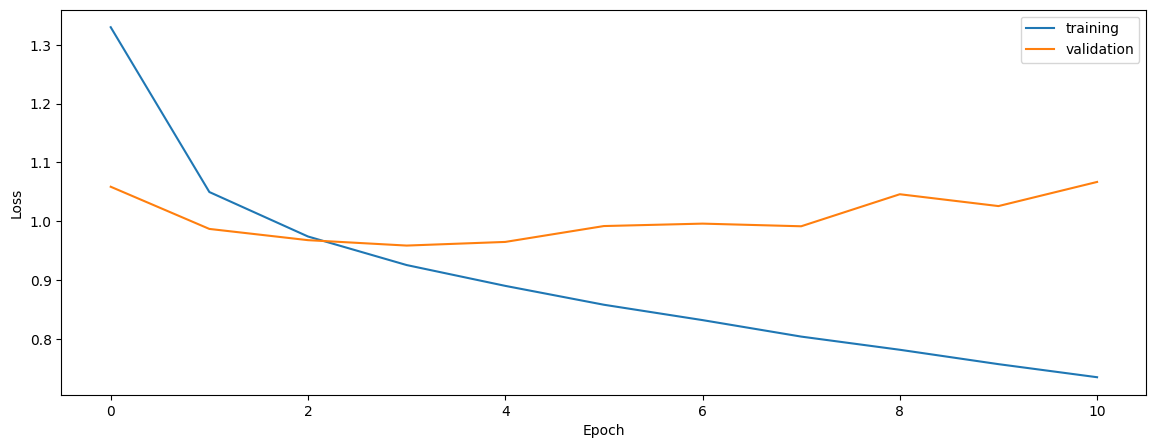

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6545054600276606
0.6172405476226489
0.6195583478506247


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5946617018780153
0.6018571111056232
0.551847770185879


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5841572708875398
0.5793440619270728
0.5413940613990941


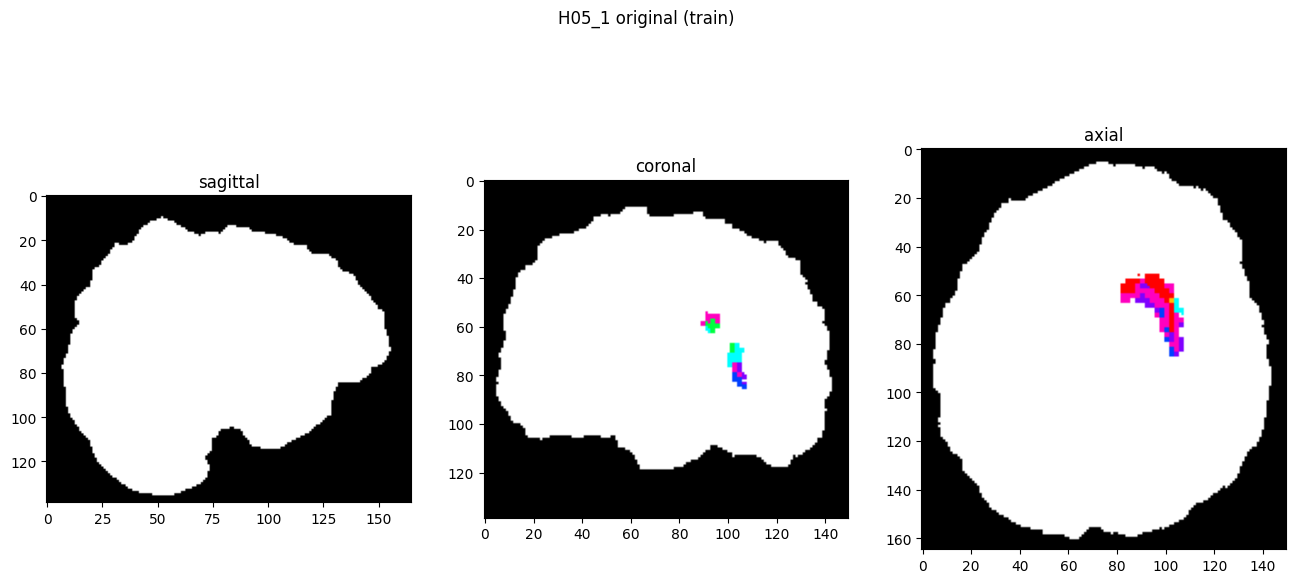

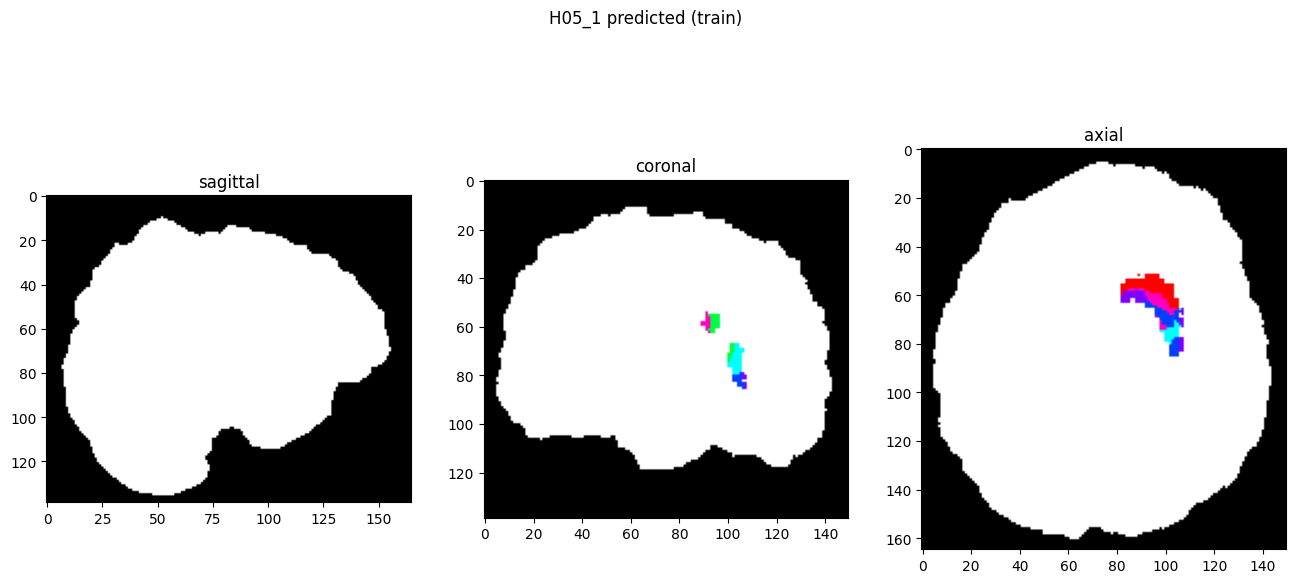

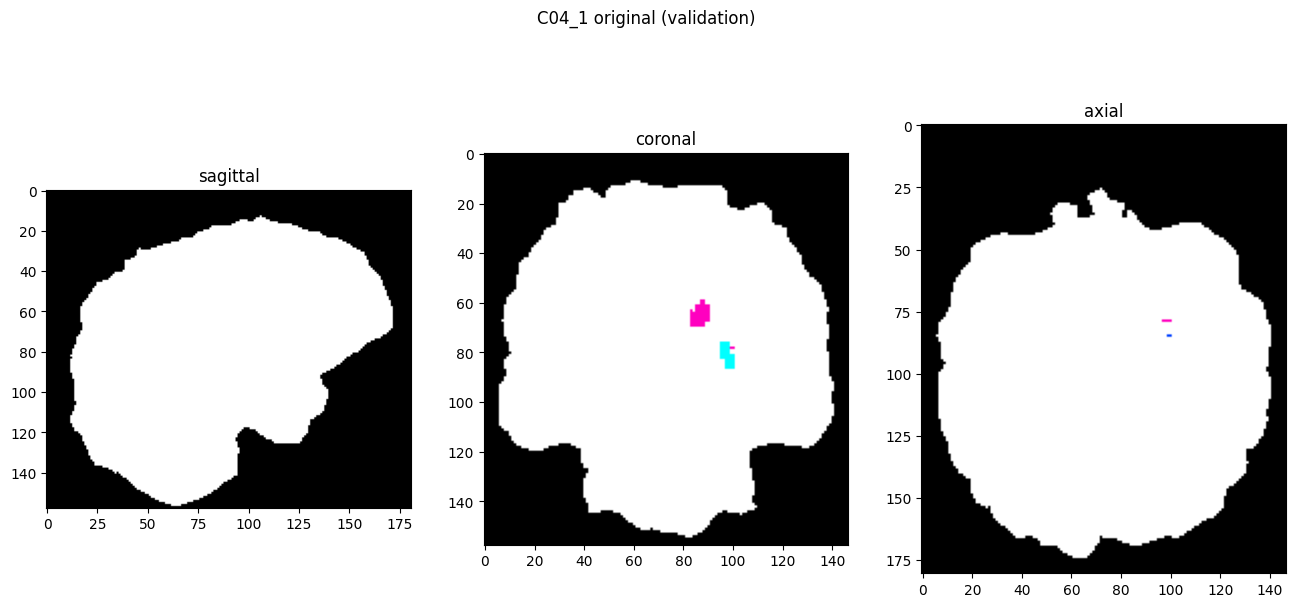

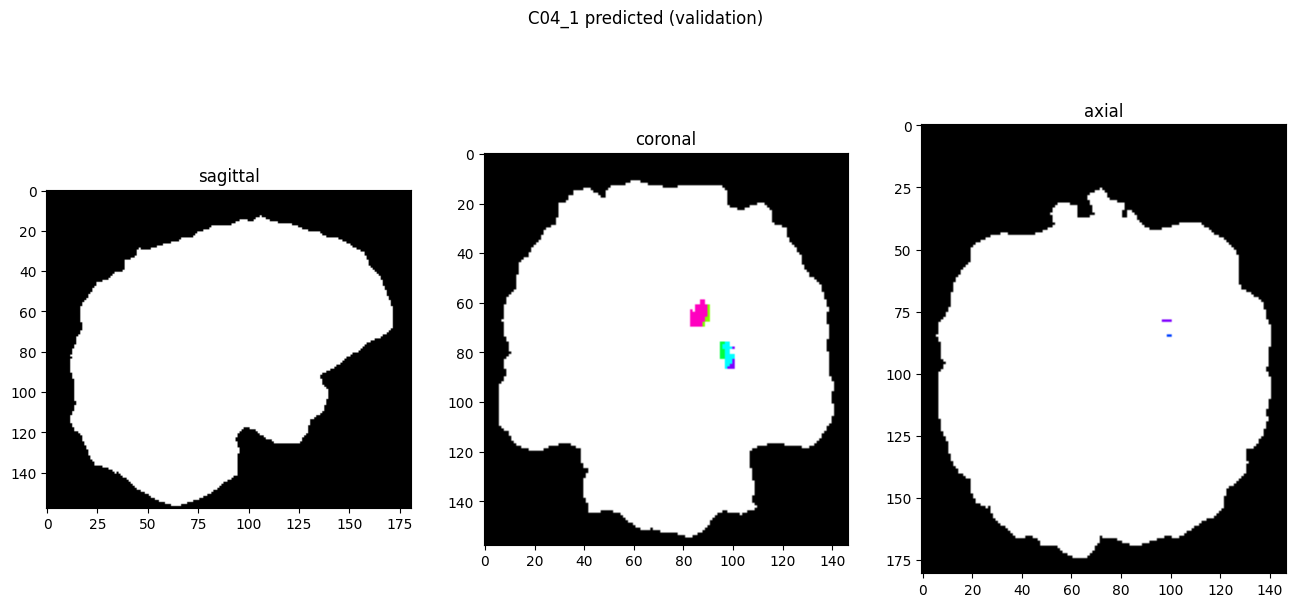

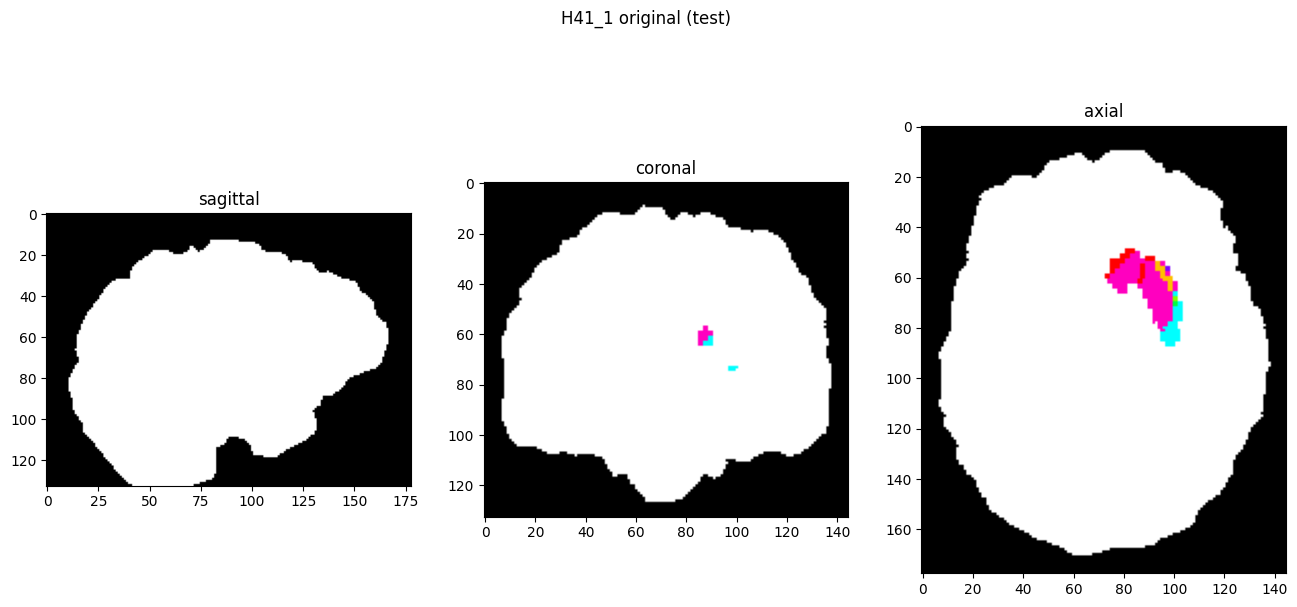

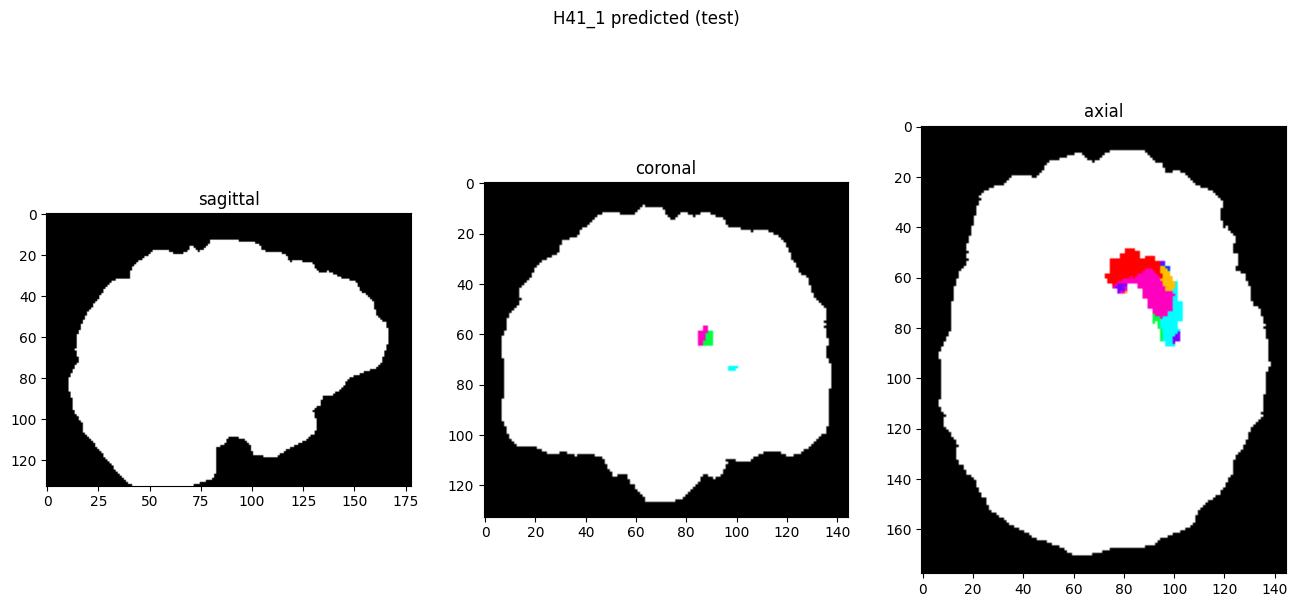

In [10]:
showResults(model, gen, threshold=0)